In [3]:
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from os import path
from utils import *

import pandas as pd
HDFStore=pd.HDFStore

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [20, 10]
plt.style.use('fivethirtyeight')
import random


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np

from glob import glob
import os
from scipy.signal import resample


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# training parameters
seed= 38

dr=0.2
lr2=1e-320
lr1=1e-4
lr=8e-4

num_epochs=1000
mini_batch_size=8

main_units=64
secondary_units=16
last_unit=8
lstm_units=64
num_classes=1

today="20220908"

print_sample=False

In [4]:
files = glob('/data/elekin/data/results/fmri/preproc/cbl/*/cbl_extracted_ts_{}.csv'.format(today))
data = []
for file in files:
    df = pd.read_csv(file, header=None)
    data.append(df.values)
features = np.array(data)
features.shape

(105, 158, 28)

In [6]:
flatten_features = features.reshape(features.shape[0], features.shape[1]*features.shape[2])
flatten_features.shape

(105, 4424)

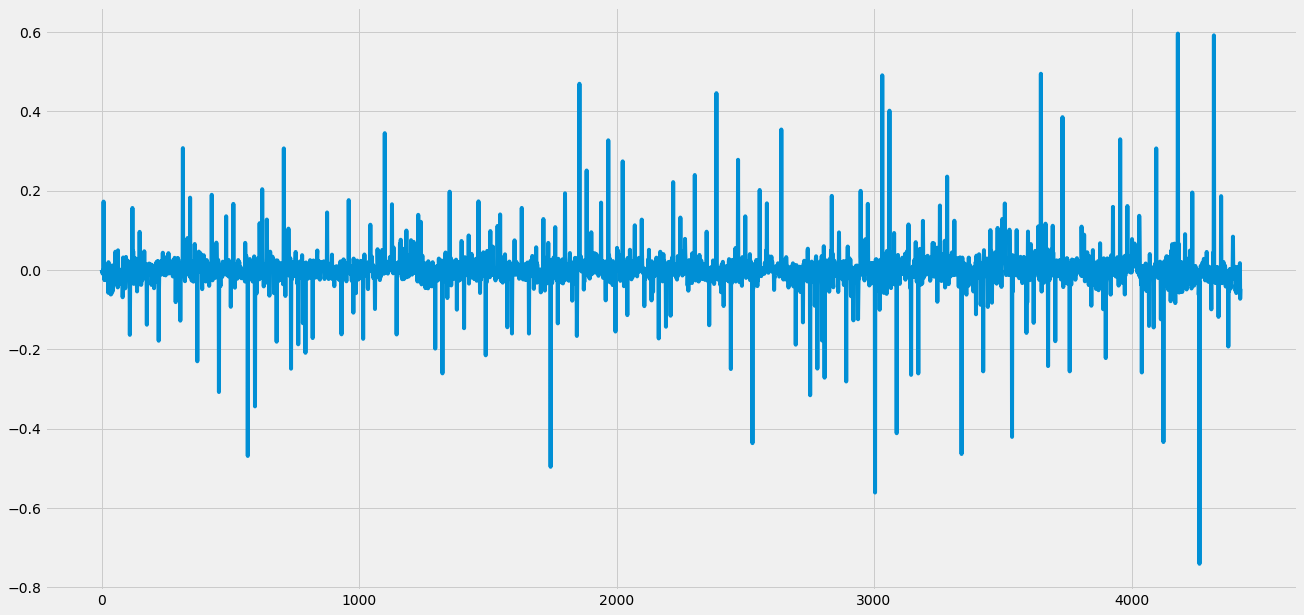

In [9]:
plt.style.use('fivethirtyeight')

idx = random.randint(0,105)
_=plt.plot(flatten_features[0])

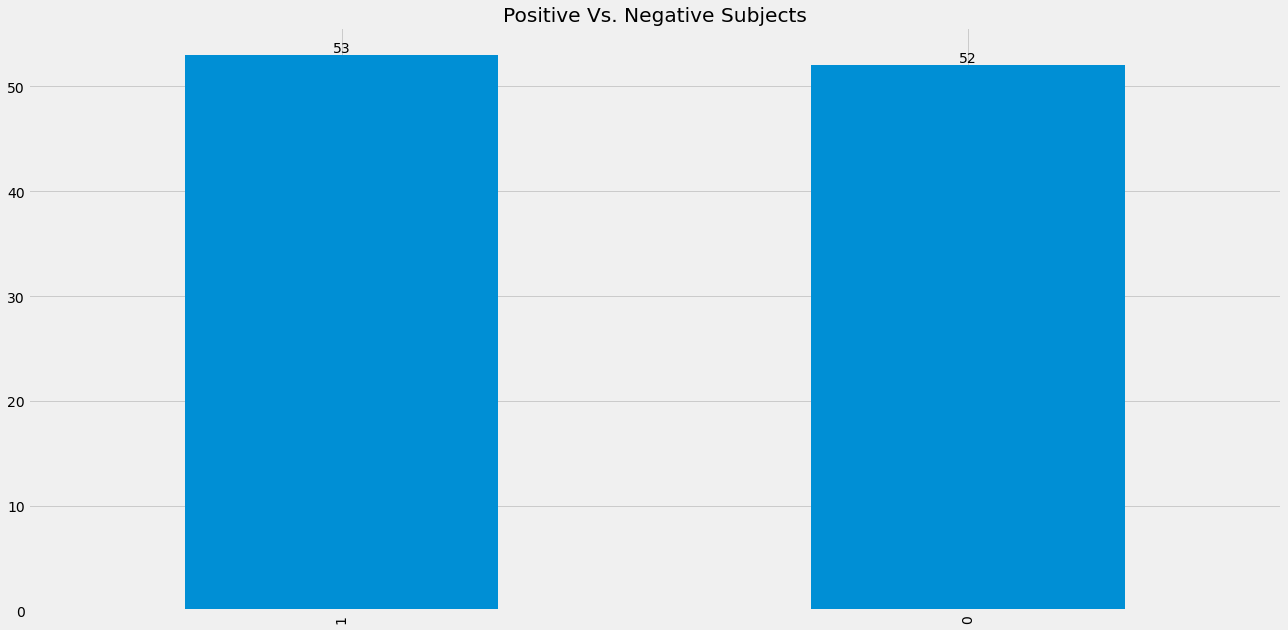

In [10]:
levels = pd.read_csv('/data/elekin/data/results/fmri/preproc/cbl/cbl_levels_{}.csv'.format(today),index_col=0)
levels.sample(5)
labels = (levels.Level > 0).astype(np.int16)
ax = labels.value_counts().plot.bar(title='Positive Vs. Negative Subjects', x='counts')
_ = ax.bar_label(ax.containers[0])

In [11]:
from sklearn import preprocessing
#multi labels
#lb = preprocessing.LabelBinarizer()
#y = lb.fit_transform(labels).astype(np.int16)
#y.shape
#binary labels
le = LabelEncoder().fit(labels.values.ravel())
y = le.fit_transform(labels.values.ravel()).astype(np.int16)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int16)

In [14]:
X = flatten_features.astype(np.float32)
X.shape

(105, 4424)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [16]:
x_train.shape, x_test.shape

((70, 4424), (35, 4424))

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).take(len(x_train)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).take(len(x_test)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
steps_per_epoch = round(len(train_dataset)/mini_batch_size)

if print_sample:
    for feat, targ in test_dataset.take(10):
        print ('Features test: {}, Target: {}'.format(feat, targ))

    for feat, targ in test_dataset.take(10):
        print ('Features train: {}, Target: {}'.format(feat, targ))

print("{0} train batches and {1} test batches of {2} mini batch size and {3} steps per epoch".format(len(train_dataset), 
                                                                              len(test_dataset),
                                                                              mini_batch_size,
                                                                                steps_per_epoch))

9 train batches and 5 test batches of 8 mini batch size and 1 steps per epoch


## FCNN ARCHITECTURE ANALISYS

Some training helpers functions

In [18]:
def get_callbacks(name):
    return [
        #tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, min_delta=1e-4),
        #tf.keras.callbacks.TensorBoard(logdir/name),
      ]

def compile_and_fit(model, train_dataset, test_dataset, name, optimizer=None, max_epochs=1000):
    tf.keras.backend.clear_session()# avoid clutter from old models and layers, especially when memory is limited
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    tf.random.set_seed(seed) # establecemos la semilla para tensorflow
    history = model.fit(train_dataset, 
                        use_multiprocessing=True, 
                        validation_data=test_dataset, epochs=max_epochs, 
                        callbacks=get_callbacks(name),
                        verbose=1, shuffle=False)
    return history

# Many models train better if you gradually reduce the learning rate during training. 
# Use optimizers.schedules to reduce the learning rate over time:
def get_optimizer(steps_per_epoch=1, lr=1e-4, multiplier=1000):
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(lr,
                                                                 decay_steps=steps_per_epoch*multiplier,
                                                                 decay_rate=1,
                                                                 staircase=False)
    return tf.keras.optimizers.Adam(lr_schedule)

In [19]:
size_histories = {}

In [20]:
num_features = x_train.shape[1]
tiny = tf.keras.models.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)])

size_histories['fcnn/tiny'] = compile_and_fit(tiny, train_dataset, 
                                              test_dataset,
                                              "fcnn/tiny", 
#                                               optimizer=get_optimizer(),
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/tiny'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/tiny'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                283200    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 283,265
Trainable params: 283,265
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
9/9 [==============================] - 1s 12ms/step - loss: 0.6879 - accuracy: 0.5857 - val_loss: 0.6904 - val_accuracy: 0.5429
Epoch 2/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.5678 - accuracy: 1.0000 - val_loss: 0.6886 - val_accuracy: 0.5714
Epoch 3/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.4999 - accuracy: 1.0000 - val_loss: 0.6873 - val_accuracy: 0.6000
Epoch 4/1000
9/9 [=======

9/9 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.8694 - val_accuracy: 0.5143
Epoch 55/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.8717 - val_accuracy: 0.5143
Epoch 56/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.8741 - val_accuracy: 0.5143
Epoch 57/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.8764 - val_accuracy: 0.5143
Epoch 58/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.8786 - val_accuracy: 0.5143
Epoch 59/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.8808 - val_accuracy: 0.5143
Epoch 60/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.8830 - val_accuracy: 0.5143
Epoch 61/1000
9/9 [========

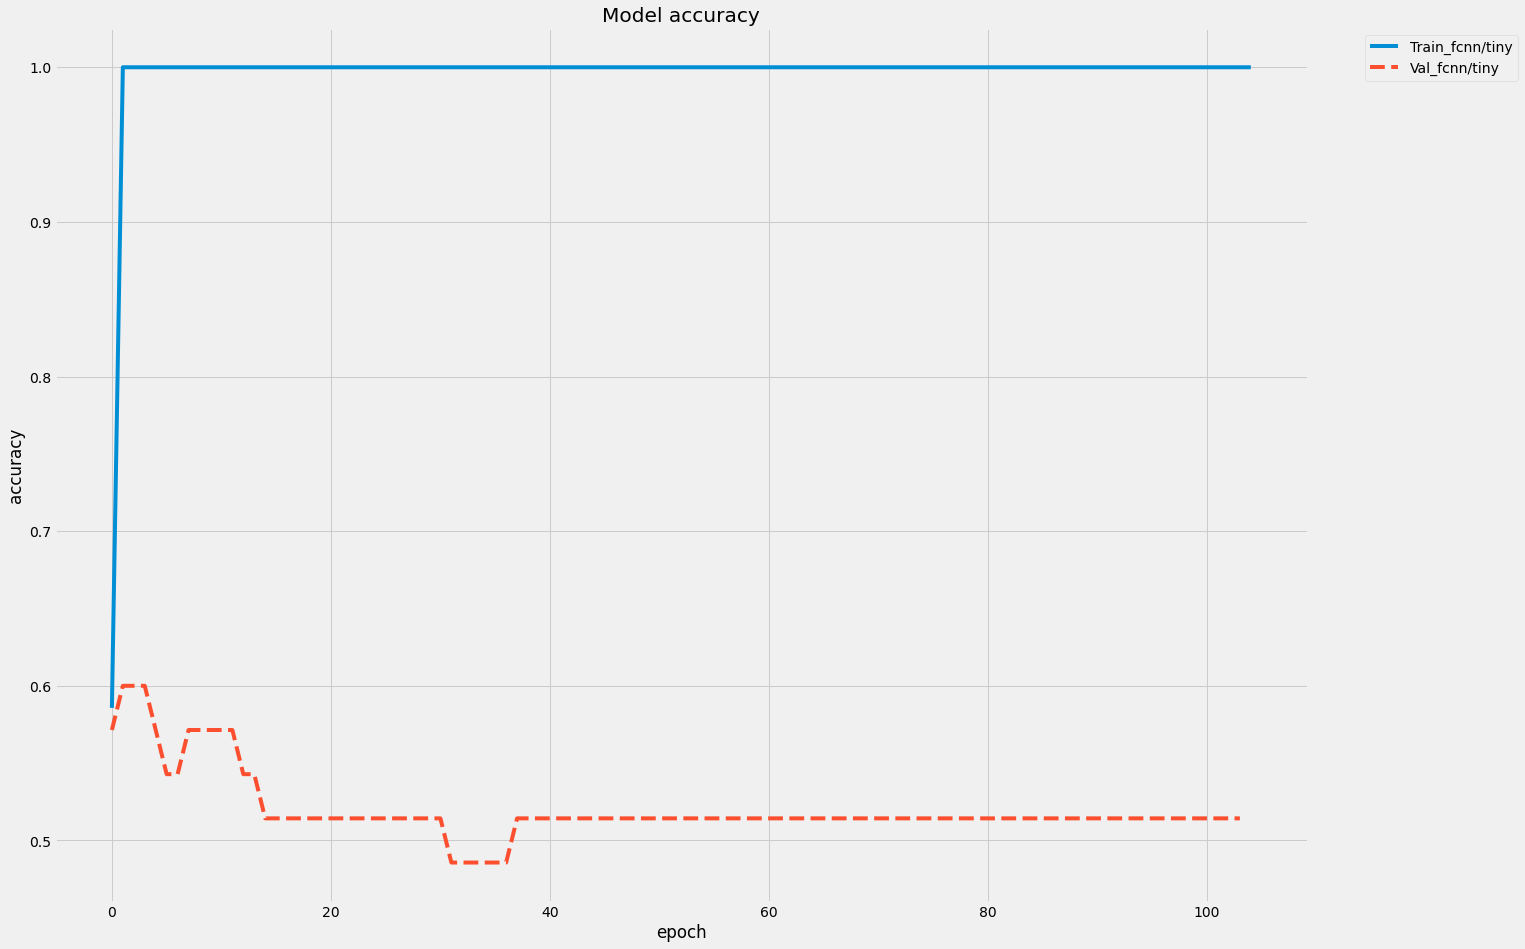

In [21]:
plt.rcParams['figure.figsize'] = [20.0, 15.0]
plot_report(size_histories, metric='accuracy')

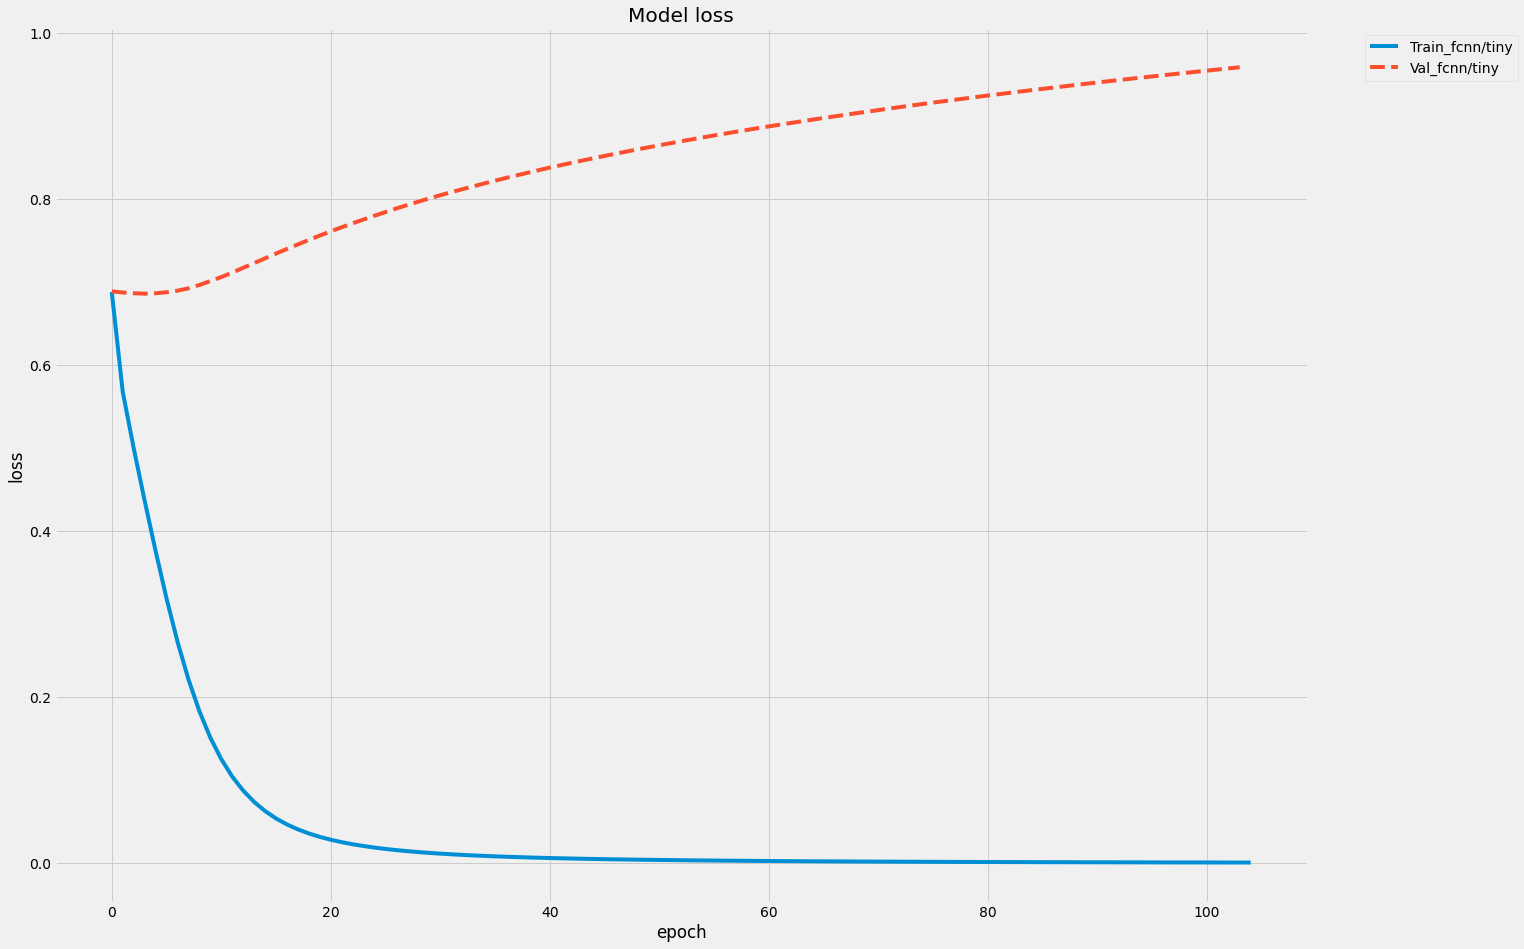

In [22]:
plot_report(size_histories, 'loss')

In [23]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/small'] = compile_and_fit(small_model, train_dataset, 
                                              test_dataset,'fcnn/small',
#                                               optimizer=get_optimizer(),
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/small'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/small'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                283200    
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 284,257
Trainable params: 284,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.7153 - accuracy: 0.4571 - val_loss: 0.6956 - val_accuracy: 0.4286
Epoch 2/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.6215 - accuracy: 0.9714 - val_loss: 0.6939 - val_accuracy: 0.4286
Epoch 3/1000
9/9 [===============

9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.9014 - val_accuracy: 0.5143
Epoch 54/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.9038 - val_accuracy: 0.5143
Epoch 55/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.9062 - val_accuracy: 0.5143
Epoch 56/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.9087 - val_accuracy: 0.5143
Epoch 57/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.9110 - val_accuracy: 0.5143
Epoch 58/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.9134 - val_accuracy: 0.5143
Epoch 59/1000
9/9 [==============================] - 0s 2ms/step - loss: 9.7187e-04 - accuracy: 1.0000 - val_loss: 0.9156 - val_accuracy: 0.5143
Epoch 60/1000
9/9 [====

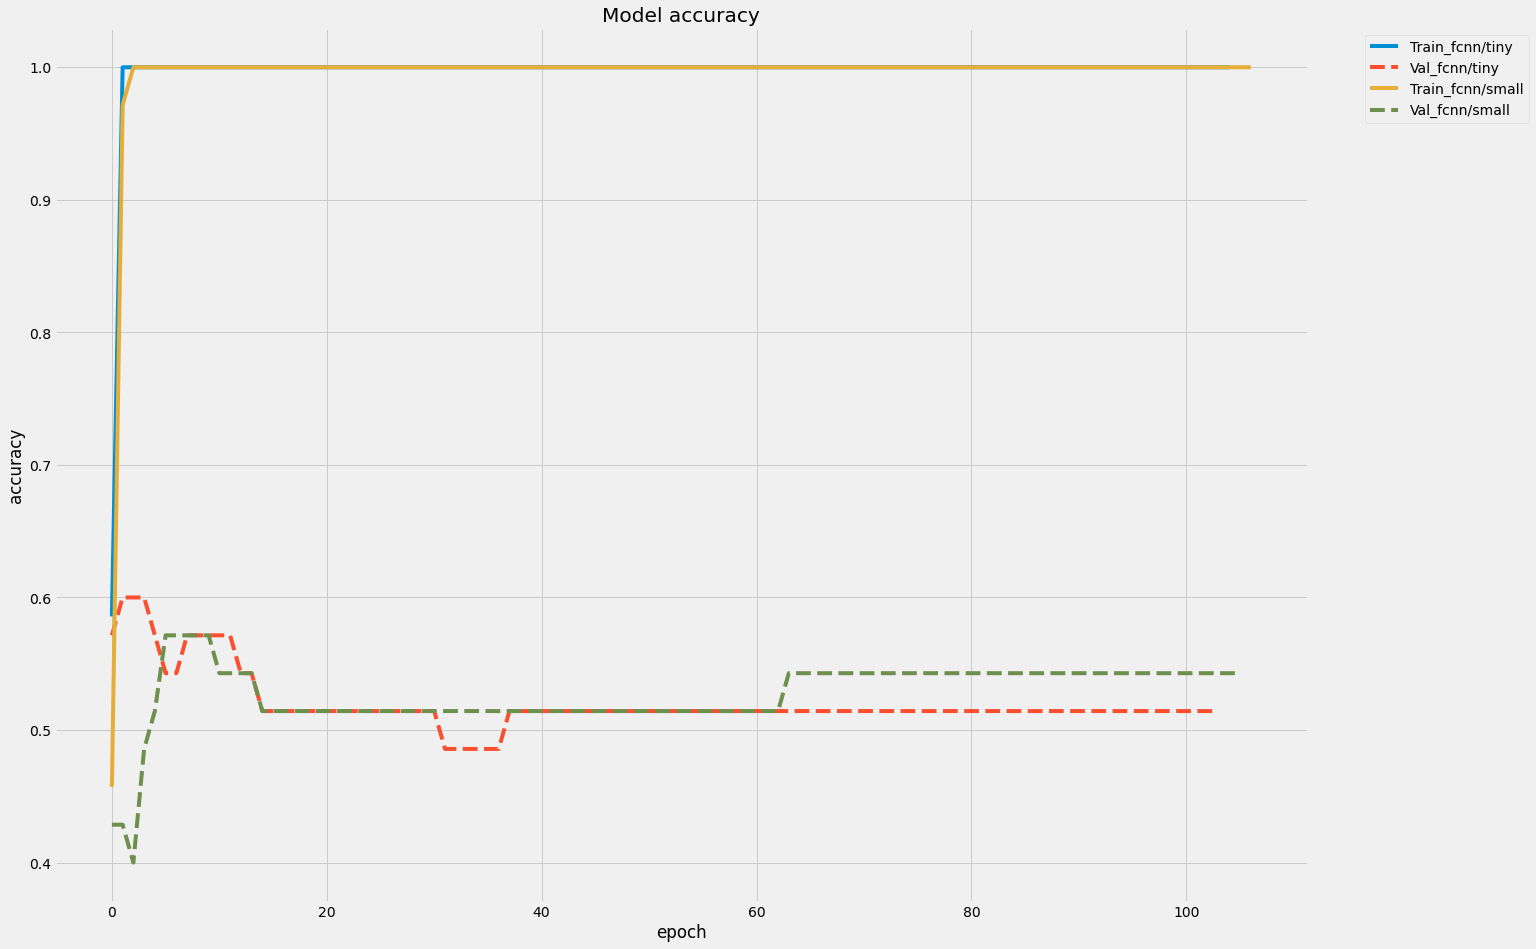

In [24]:
plot_report(size_histories)

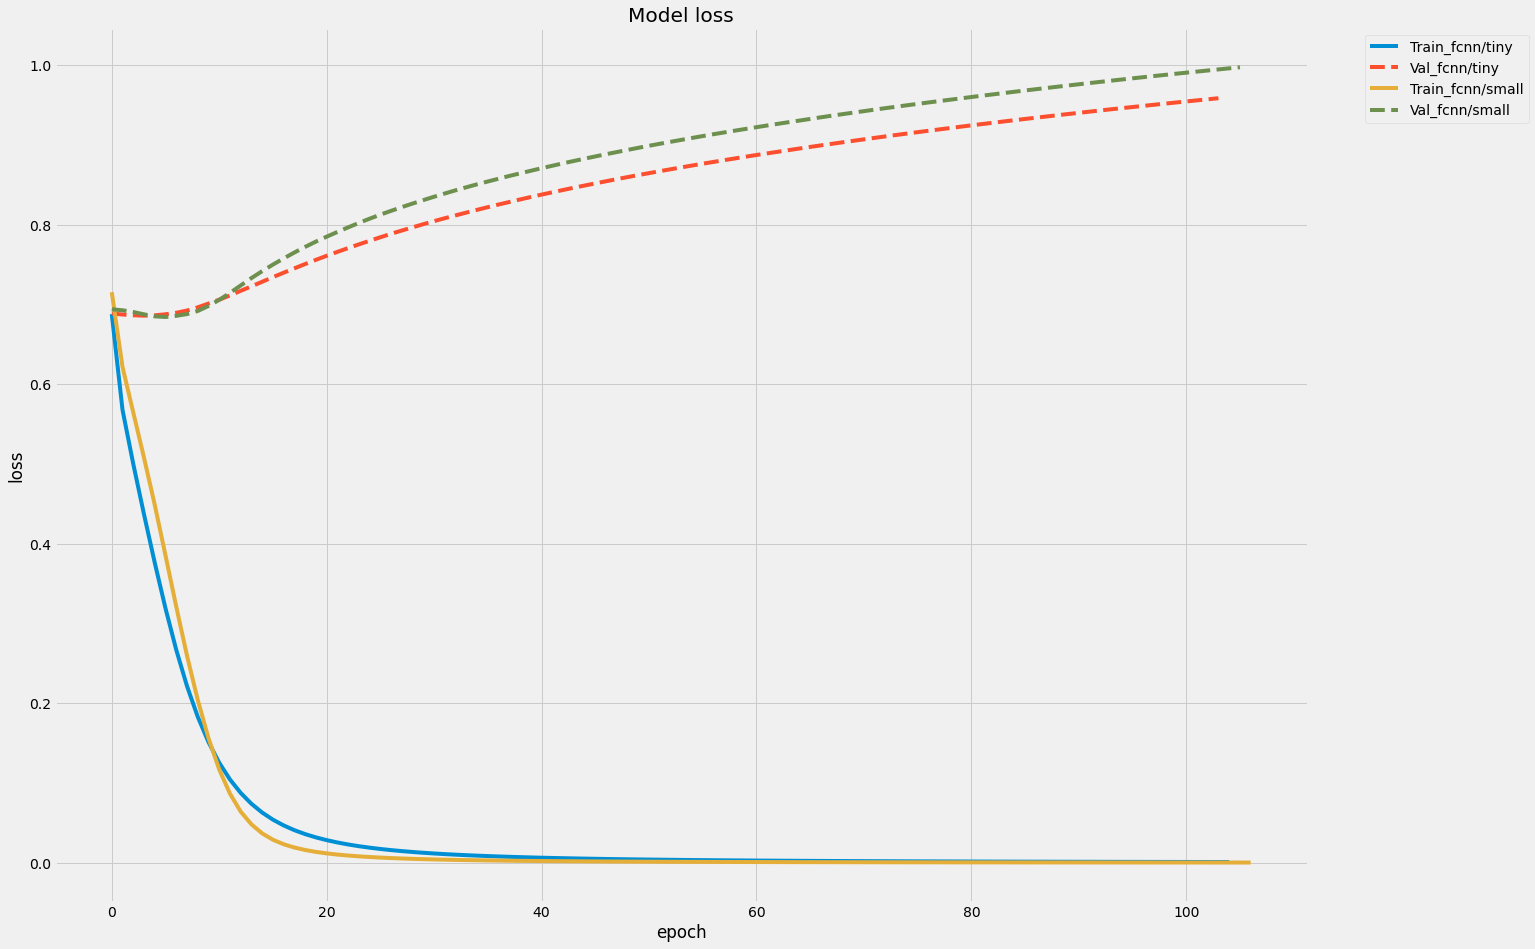

In [25]:
plot_report(size_histories, 'loss')

In [26]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),  
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/large'] = compile_and_fit(large_model, train_dataset, 
                                              test_dataset, "fcnn/large",
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer=get_optimizer(), 
                                              max_epochs=num_epochs)

print("Evaluation")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/large'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/large'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                283200    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 288,545
Trainable params: 288,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
9/9 [==============================] 

Epoch 51/1000
9/9 [==============================] - 0s 3ms/step - loss: 2.1690e-04 - accuracy: 1.0000 - val_loss: 1.1136 - val_accuracy: 0.5714
Epoch 52/1000
9/9 [==============================] - 0s 2ms/step - loss: 2.0842e-04 - accuracy: 1.0000 - val_loss: 1.1167 - val_accuracy: 0.5714
Epoch 53/1000
9/9 [==============================] - 0s 3ms/step - loss: 2.0041e-04 - accuracy: 1.0000 - val_loss: 1.1197 - val_accuracy: 0.5714
Epoch 54/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.9288e-04 - accuracy: 1.0000 - val_loss: 1.1227 - val_accuracy: 0.5714
Epoch 55/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.8576e-04 - accuracy: 1.0000 - val_loss: 1.1256 - val_accuracy: 0.5714
Epoch 56/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.7904e-04 - accuracy: 1.0000 - val_loss: 1.1285 - val_accuracy: 0.5714
Epoch 57/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.7267e-04 - accuracy: 1.0000 - val_loss: 1.1313 - val_ac

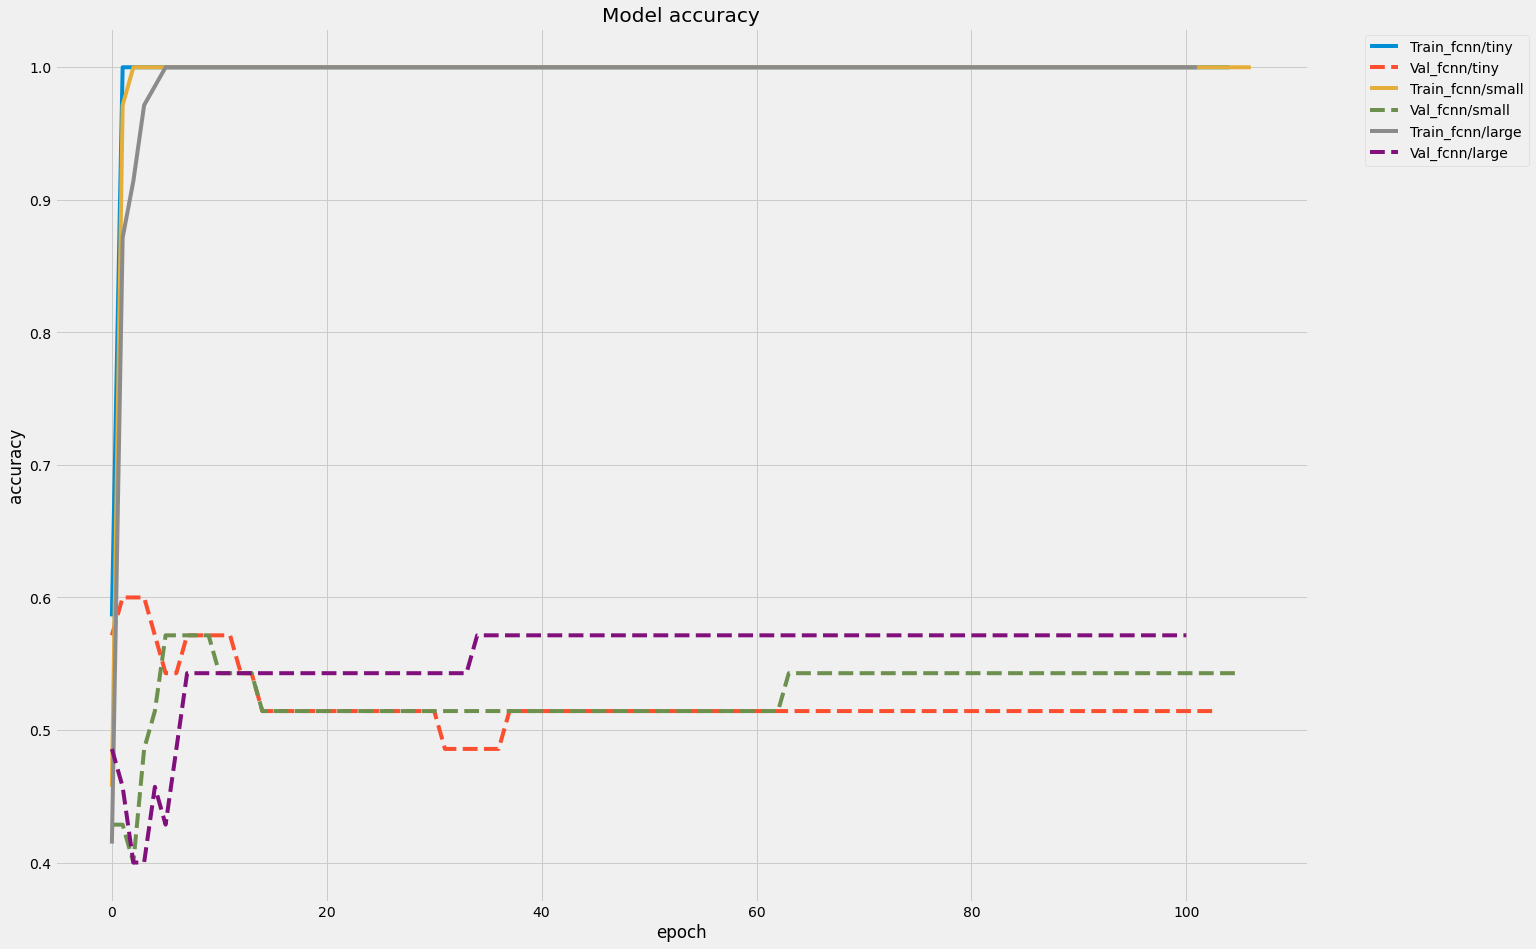

In [27]:
plot_report(size_histories)

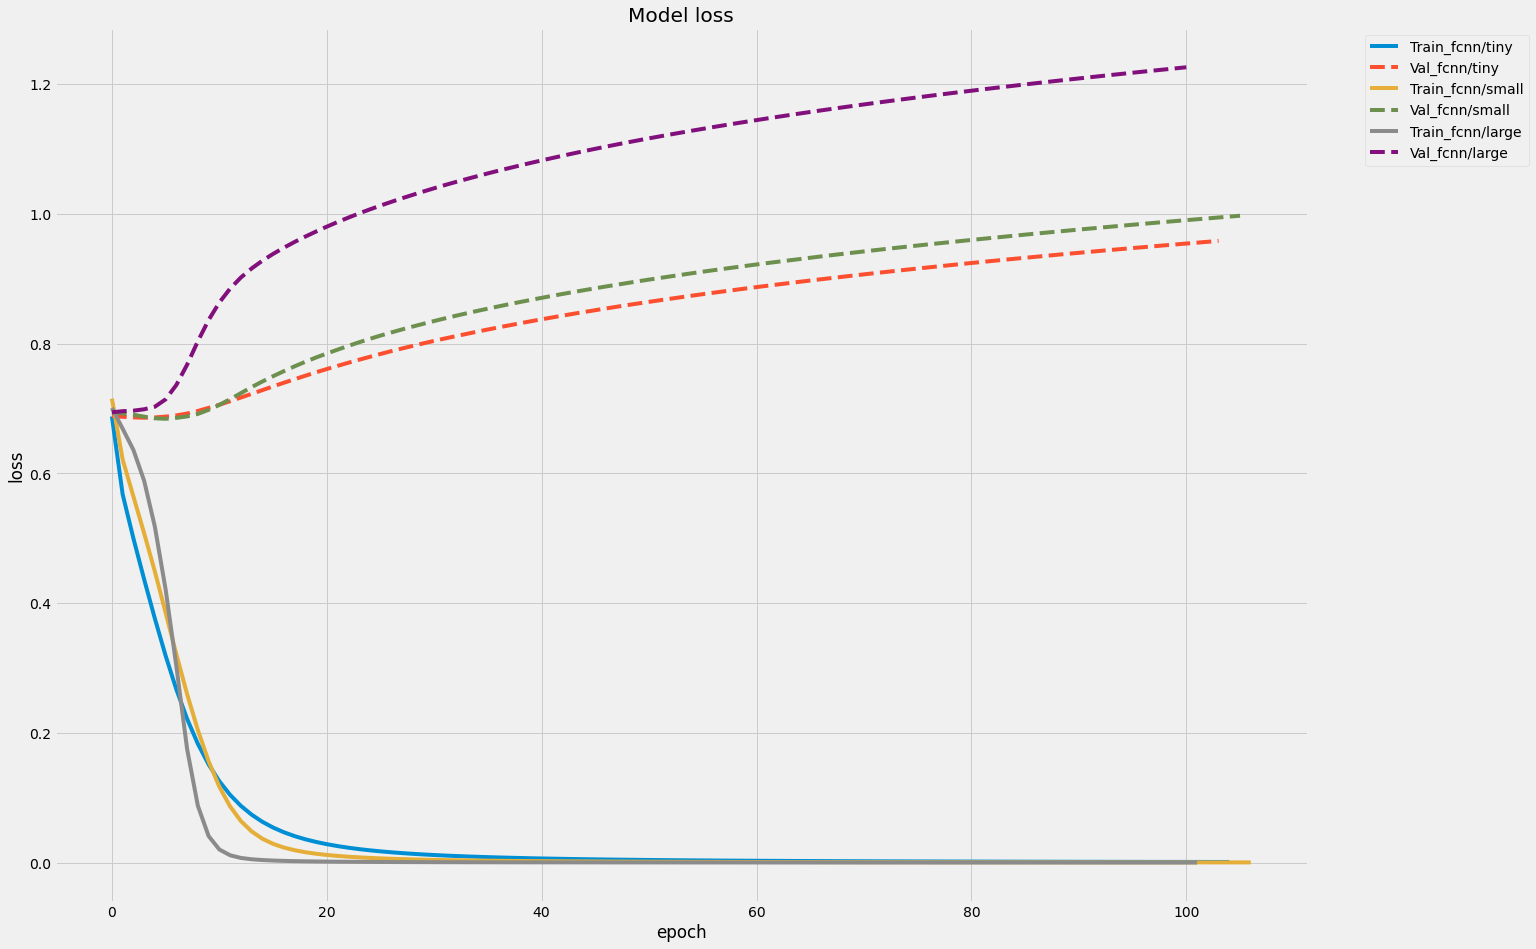

In [28]:
plot_report(size_histories, 'loss')

### Dropout

Although we got an accuracy of 0.75 looking at loss function chart is pretty obvious: There is overfiting. Now we have an overfitted NN let's make some adjustments to improve generalization capacity startin from dropout techniques.  

In [29]:
tiny_dropout = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/tiny/dropout'] = compile_and_fit(tiny_dropout, 
                                                      train_dataset,
                                                      test_dataset,
                                                      "fcnn/tiny/dropout", 
                                                      optimizer=tf.keras.optimizers.Adam(lr), 
                                                      max_epochs=num_epochs)

print("\n#######################EVALUATIO######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/tiny/dropout'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/tiny/dropout'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                283200    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                 9

9/9 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.6075 - val_accuracy: 0.4571
Epoch 50/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.6396 - val_accuracy: 0.4571
Epoch 51/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.6590 - val_accuracy: 0.4571
Epoch 52/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 1.6743 - val_accuracy: 0.4571
Epoch 53/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 1.6843 - val_accuracy: 0.4571
Epoch 54/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 1.6956 - val_accuracy: 0.4571
Epoch 55/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.7077 - val_accuracy: 0.4571
Epoch 56/1000
9/9 [========

9/9 [==============================] - 0s 2ms/step - loss: 4.8299e-05 - accuracy: 1.0000 - val_loss: 2.1954 - val_accuracy: 0.5143

#######################EVALUATIO######################
train acc: 1.0
test acc: 0.5714285969734192


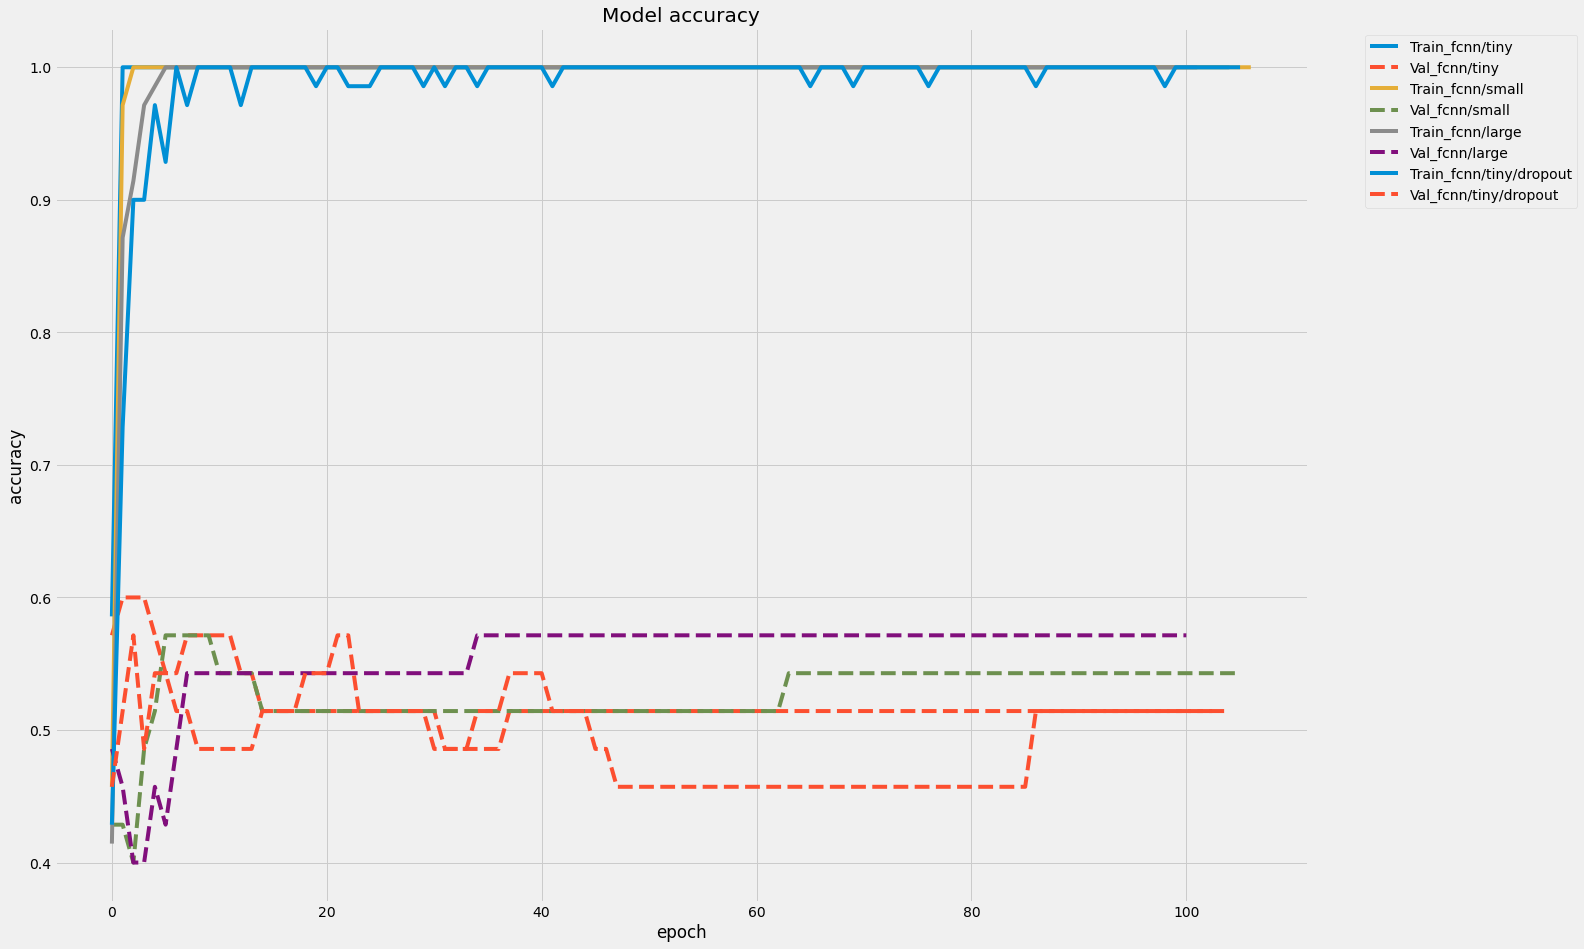

In [30]:
plot_report(size_histories)

Validation accuracy keeps improving more epoch with a total improvement from 0.75 to 0.81. Furthemore, the gap between training loss function and test loss function has been reduced.

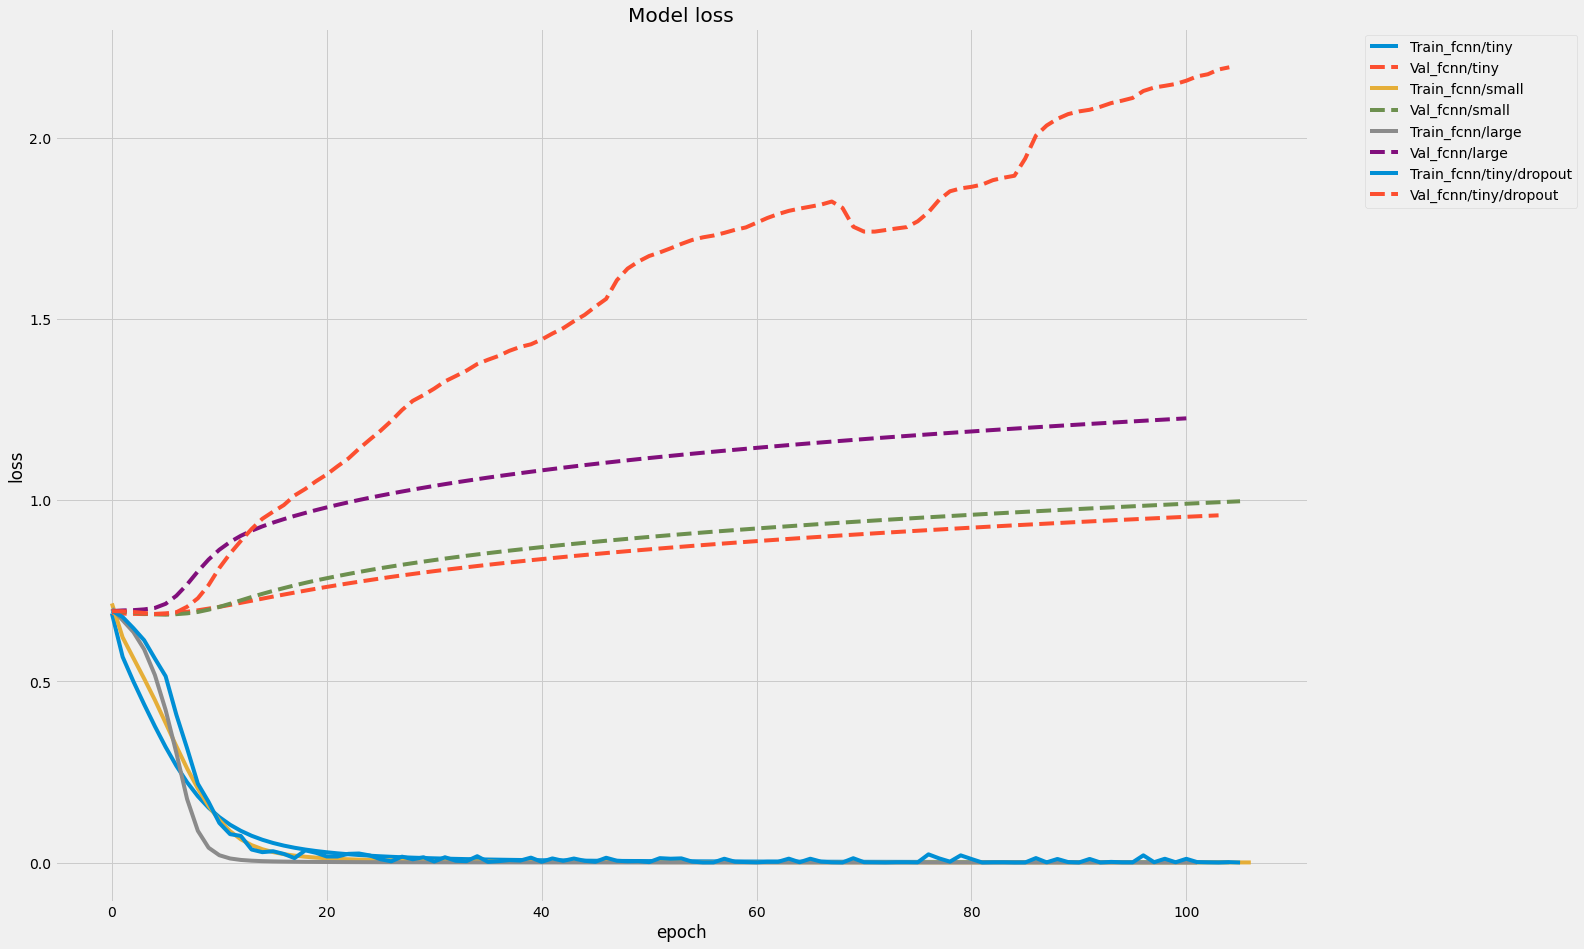

In [31]:
plot_report(size_histories, metric='loss')

### Kernel regularizer

In [32]:
# shutil.rmtree(logdir/'regularizers/tiny', ignore_errors=True)
# shutil.copytree(logdir/'fcnn/tiny', logdir/'regularizers/tiny')
regularizer_histories = {}
regularizer_histories['large'] = size_histories['fcnn/large']
regularizer_histories['dropout'] = size_histories['fcnn/tiny/dropout']

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights. one reason why L2 is more common.

In tf.keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [33]:
l2_model = tf.keras.Sequential([
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1),
                 input_shape=(num_features,)),
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(secondary_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(last_unit, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
regularizer_histories['l2'] = compile_and_fit(l2_model, train_dataset, 
                                              test_dataset, 
                                              optimizer=tf.keras.optimizers.Adam(lr),
                                              name="regularizers/l2")
# Evaluate the model on the test data using `evaluate`
print("\n#######################EVALUATIO######################")
print('train acc:', max(regularizer_histories['l2'].history["accuracy"]))
print('test acc:', max(regularizer_histories['l2'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                283200    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 288,545
Trainable params: 288,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
9/9 [==============================] 

9/9 [==============================] - 0s 3ms/step - loss: 0.0635 - accuracy: 1.0000 - val_loss: 1.5390 - val_accuracy: 0.6286
Epoch 52/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0627 - accuracy: 1.0000 - val_loss: 1.5460 - val_accuracy: 0.6286
Epoch 53/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0619 - accuracy: 1.0000 - val_loss: 1.5515 - val_accuracy: 0.6286
Epoch 54/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0612 - accuracy: 1.0000 - val_loss: 1.5604 - val_accuracy: 0.6000
Epoch 55/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.0605 - accuracy: 1.0000 - val_loss: 1.5676 - val_accuracy: 0.6000
Epoch 56/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0598 - accuracy: 1.0000 - val_loss: 1.5714 - val_accuracy: 0.6000
Epoch 57/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0591 - accuracy: 1.0000 - val_loss: 1.5756 - val_accuracy: 0.6000
Epoch 58/1000
9/9 [========

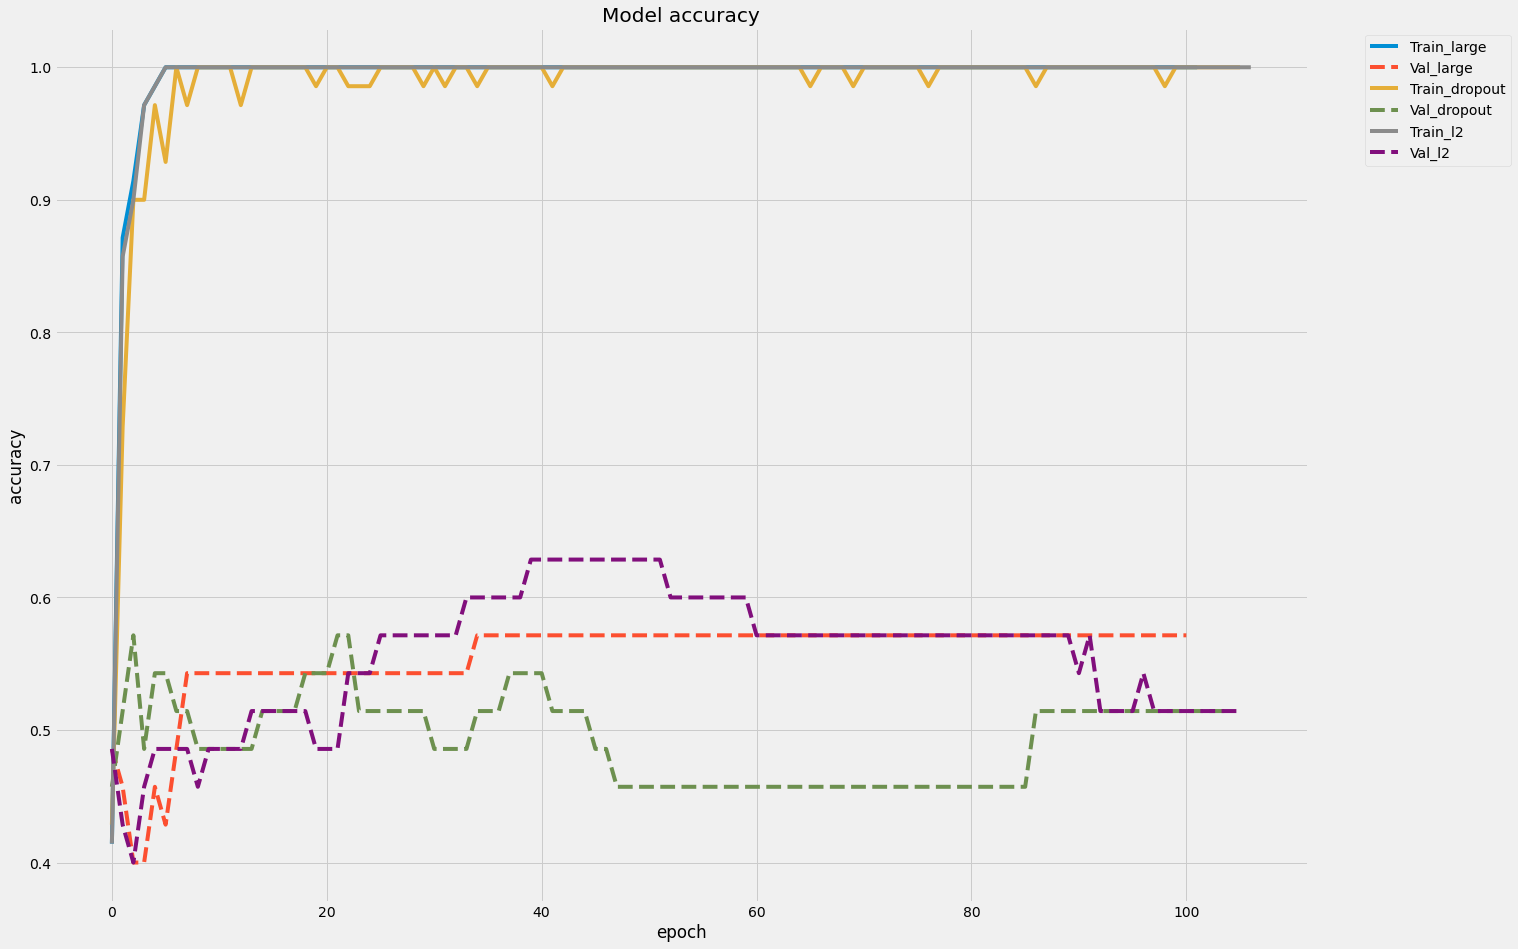

In [34]:
plot_report(regularizer_histories, 'accuracy')

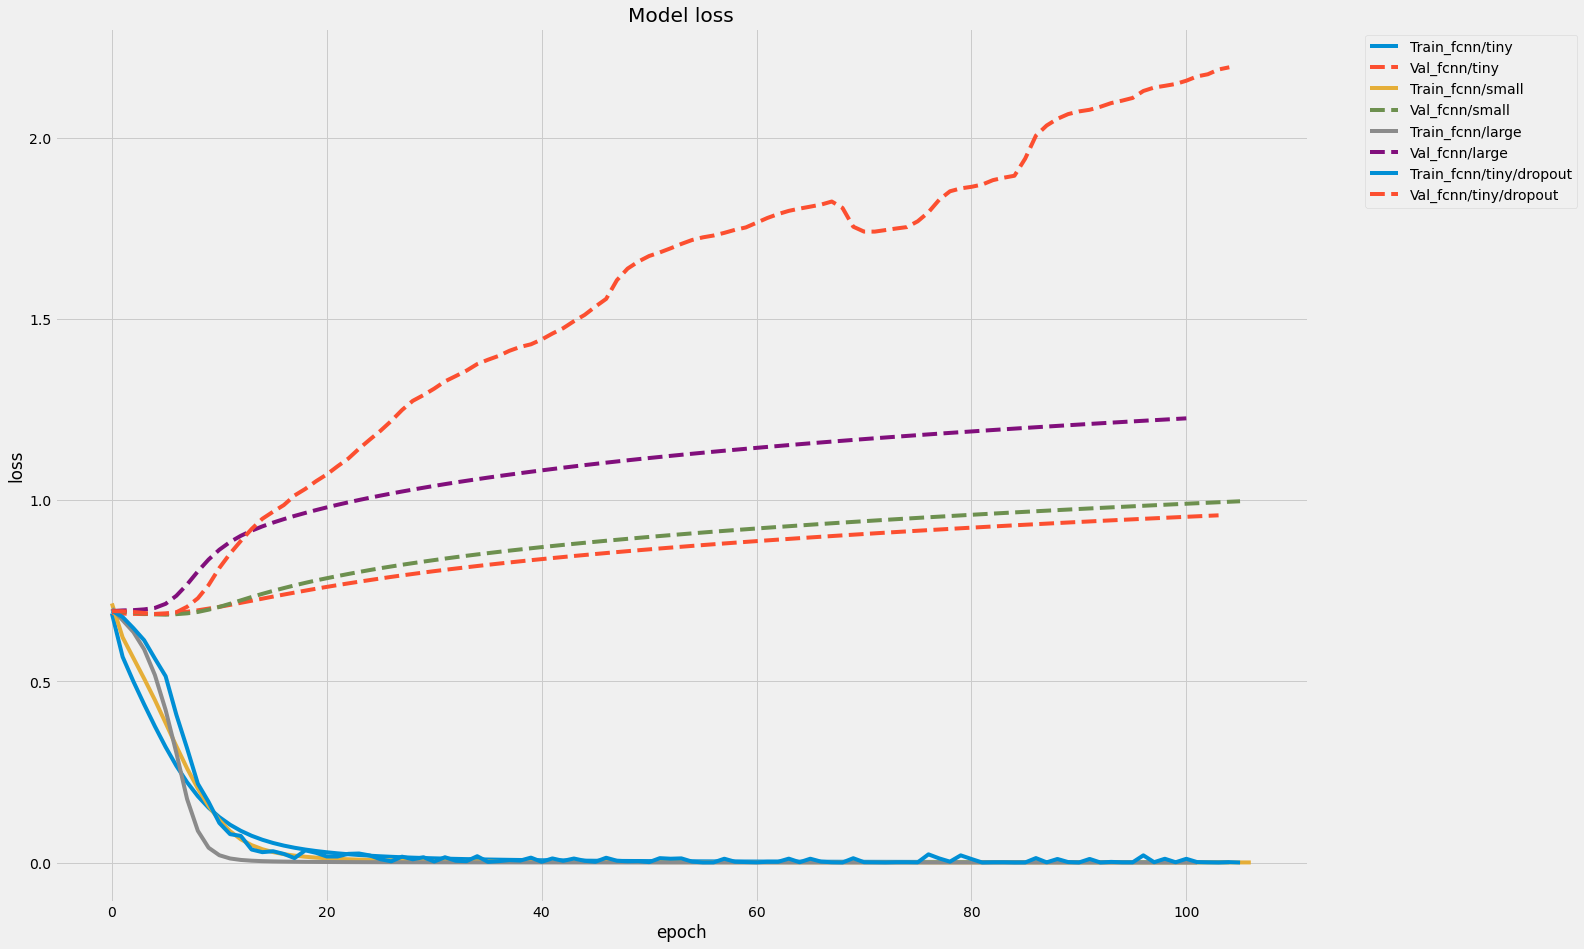

In [35]:
plot_report(size_histories, 'loss')

Now let's see what happens combining both techniques

In [36]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
combined_model = tf.keras.Sequential([
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1),
                 input_shape=(num_features,)),
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(secondary_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(last_unit, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    tf.keras.layers.Dropout(dr),
    layers.Dense(num_classes, activation=tf.nn.sigmoid)
])

tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
regularizer_histories['combined'] = compile_and_fit(combined_model, train_dataset, test_dataset, "regularizers/combined",
                                                   optimizer=get_optimizer())

# Evaluate the model on the test data using `evaluate`
print()
print('train acc:', max(regularizer_histories['combined'].history["accuracy"]))
print('test acc:', max(regularizer_histories['combined'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                283200    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 288,545
Trainable params: 288,545
Non-trai

9/9 [==============================] - 0s 3ms/step - loss: 0.6066 - accuracy: 1.0000 - val_loss: 0.9977 - val_accuracy: 0.4857
Epoch 51/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.5812 - accuracy: 0.9857 - val_loss: 0.9965 - val_accuracy: 0.4857
Epoch 52/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.5707 - accuracy: 0.9857 - val_loss: 0.9955 - val_accuracy: 0.4857
Epoch 53/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.5292 - accuracy: 1.0000 - val_loss: 0.9945 - val_accuracy: 0.4857
Epoch 54/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.5155 - accuracy: 1.0000 - val_loss: 0.9936 - val_accuracy: 0.4857
Epoch 55/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.5508 - accuracy: 1.0000 - val_loss: 0.9933 - val_accuracy: 0.4857
Epoch 56/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.4858 - accuracy: 1.0000 - val_loss: 0.9928 - val_accuracy: 0.4857
Epoch 57/1000
9/9 [========

9/9 [==============================] - 0s 3ms/step - loss: 0.2359 - accuracy: 1.0000 - val_loss: 1.0490 - val_accuracy: 0.4571
Epoch 109/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.2847 - accuracy: 1.0000 - val_loss: 1.0508 - val_accuracy: 0.4571
Epoch 110/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.2508 - accuracy: 1.0000 - val_loss: 1.0528 - val_accuracy: 0.4571
Epoch 111/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.2493 - accuracy: 1.0000 - val_loss: 1.0538 - val_accuracy: 0.4571
Epoch 112/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.2562 - accuracy: 1.0000 - val_loss: 1.0550 - val_accuracy: 0.4571
Epoch 113/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.2597 - accuracy: 1.0000 - val_loss: 1.0569 - val_accuracy: 0.4571
Epoch 114/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.2512 - accuracy: 1.0000 - val_loss: 1.0583 - val_accuracy: 0.4571
Epoch 115/1000
9/9 [=

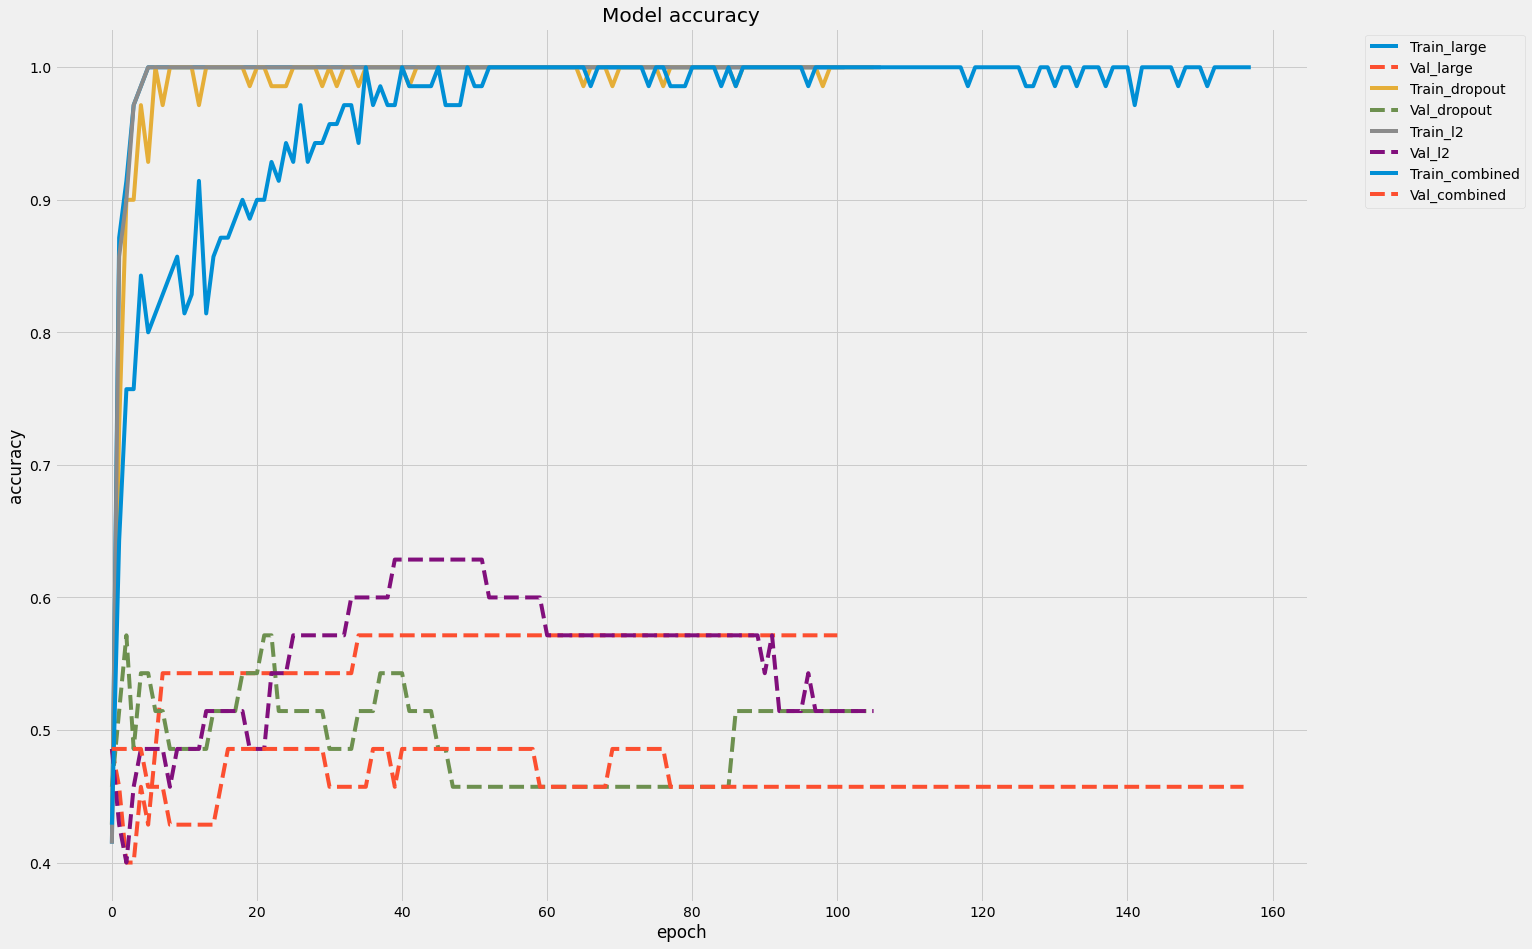

In [37]:
plot_report(regularizer_histories, 'accuracy')

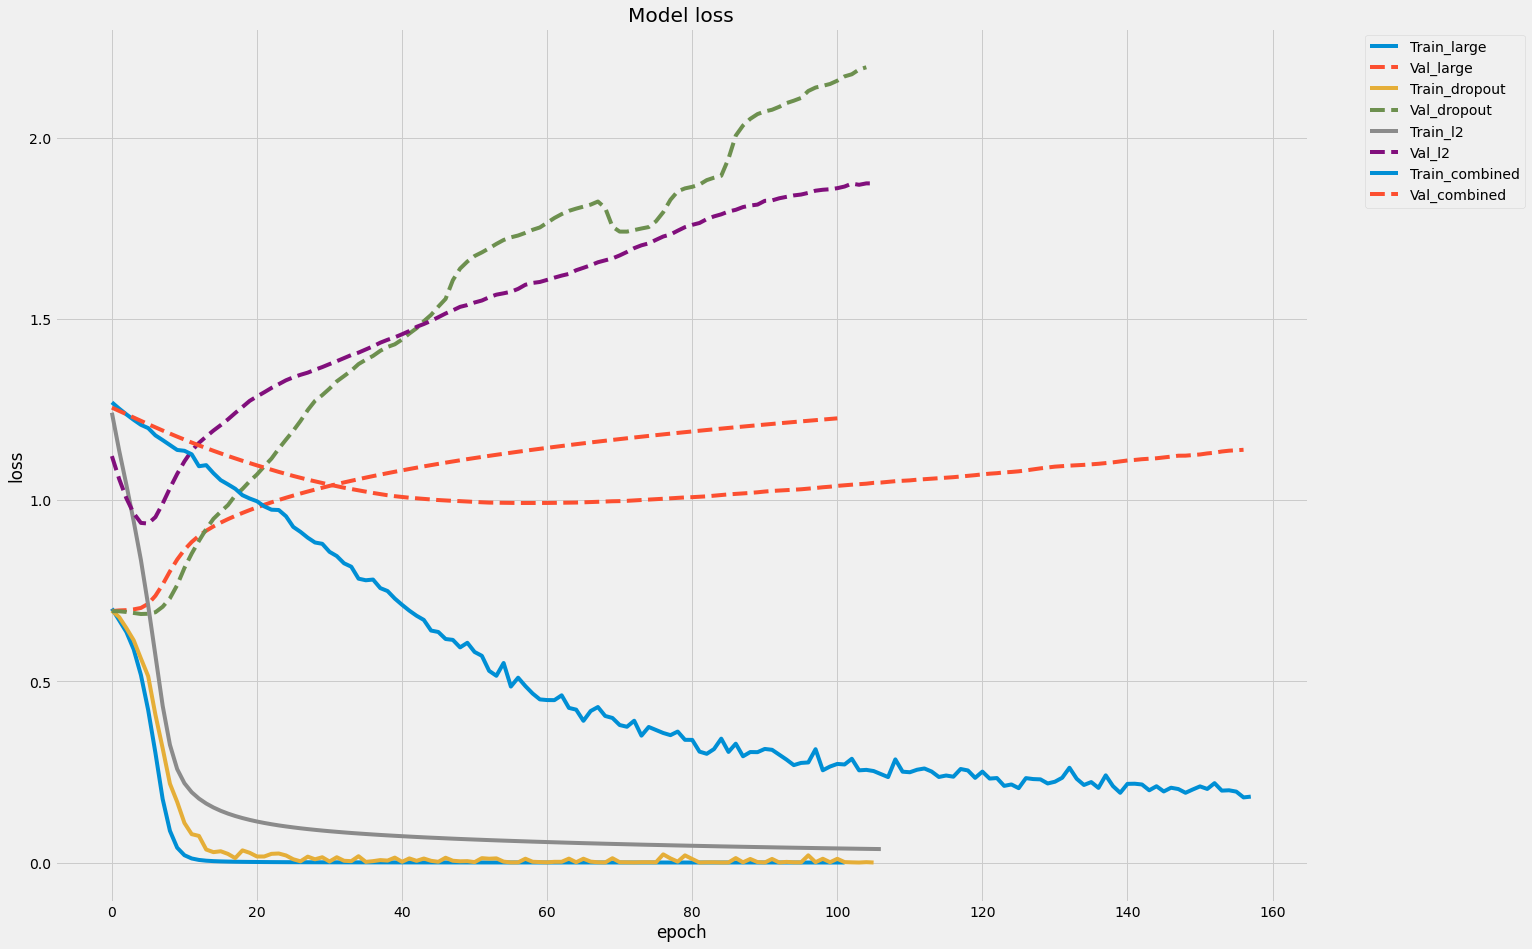

In [38]:
plot_report(regularizer_histories, 'loss')

## Batch Normalization

Batch normalization (also known as batch norm) is a method used to make artificial neural networks faster and more stable through normalization of the input layer by re-centering and re-scaling. It was proposed by Sergey Ioffe and Christian Szegedy in 2015.

[Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

[Tensorflow implementation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)


In [39]:
batch_histories = {}
batch_histories['large'] = size_histories['fcnn/large']
batch_histories['dropout'] = size_histories['fcnn/tiny/dropout']

In [40]:
small_batch = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
batch_histories['fcnn/small/batch'] = compile_and_fit(small_batch, 
                                                      train_dataset,
                                                      test_dataset,
                                                      "fcnn/small/batch", 
                                                      optimizer=tf.keras.optimizers.Adam(lr), 
                                                      max_epochs=num_epochs)

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(batch_histories['fcnn/small/batch'].history["accuracy"]))
print('test acc:', max(batch_histories['fcnn/small/batch'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                283200    
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 batch_normalization_2 (Batc  (None, 16)               6

Epoch 45/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1351 - accuracy: 0.9714 - val_loss: 0.7171 - val_accuracy: 0.5429
Epoch 46/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1357 - accuracy: 0.9571 - val_loss: 0.7210 - val_accuracy: 0.5714
Epoch 47/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1219 - accuracy: 0.9857 - val_loss: 0.7235 - val_accuracy: 0.5714
Epoch 48/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0969 - accuracy: 1.0000 - val_loss: 0.7248 - val_accuracy: 0.5714
Epoch 49/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1192 - accuracy: 0.9714 - val_loss: 0.7259 - val_accuracy: 0.6000
Epoch 50/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1313 - accuracy: 0.9714 - val_loss: 0.7301 - val_accuracy: 0.6000
Epoch 51/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1345 - accuracy: 0.9571 - val_loss: 0.7365 - val_accuracy: 0.6000
Epoch 52/1000

9/9 [==============================] - 0s 4ms/step - loss: 0.1098 - accuracy: 0.9714 - val_loss: 0.8450 - val_accuracy: 0.5143
Epoch 104/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0636 - accuracy: 0.9857 - val_loss: 0.8492 - val_accuracy: 0.5429

#######################EVALUATION######################
train acc: 1.0
test acc: 0.6000000238418579


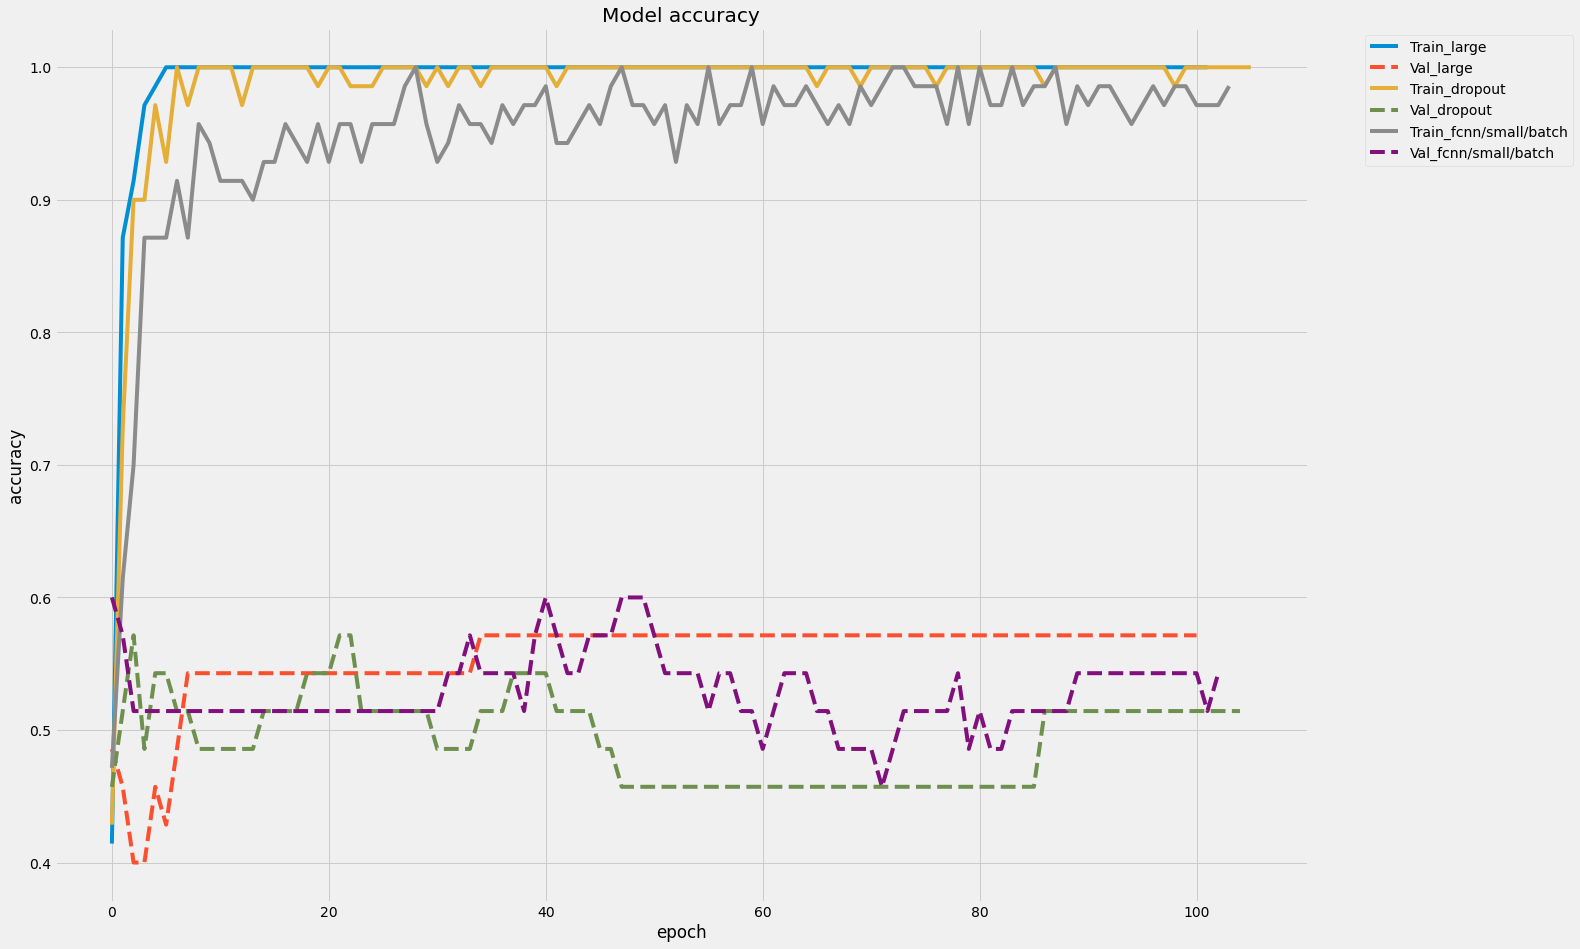

In [41]:
plot_report(batch_histories, 'accuracy')

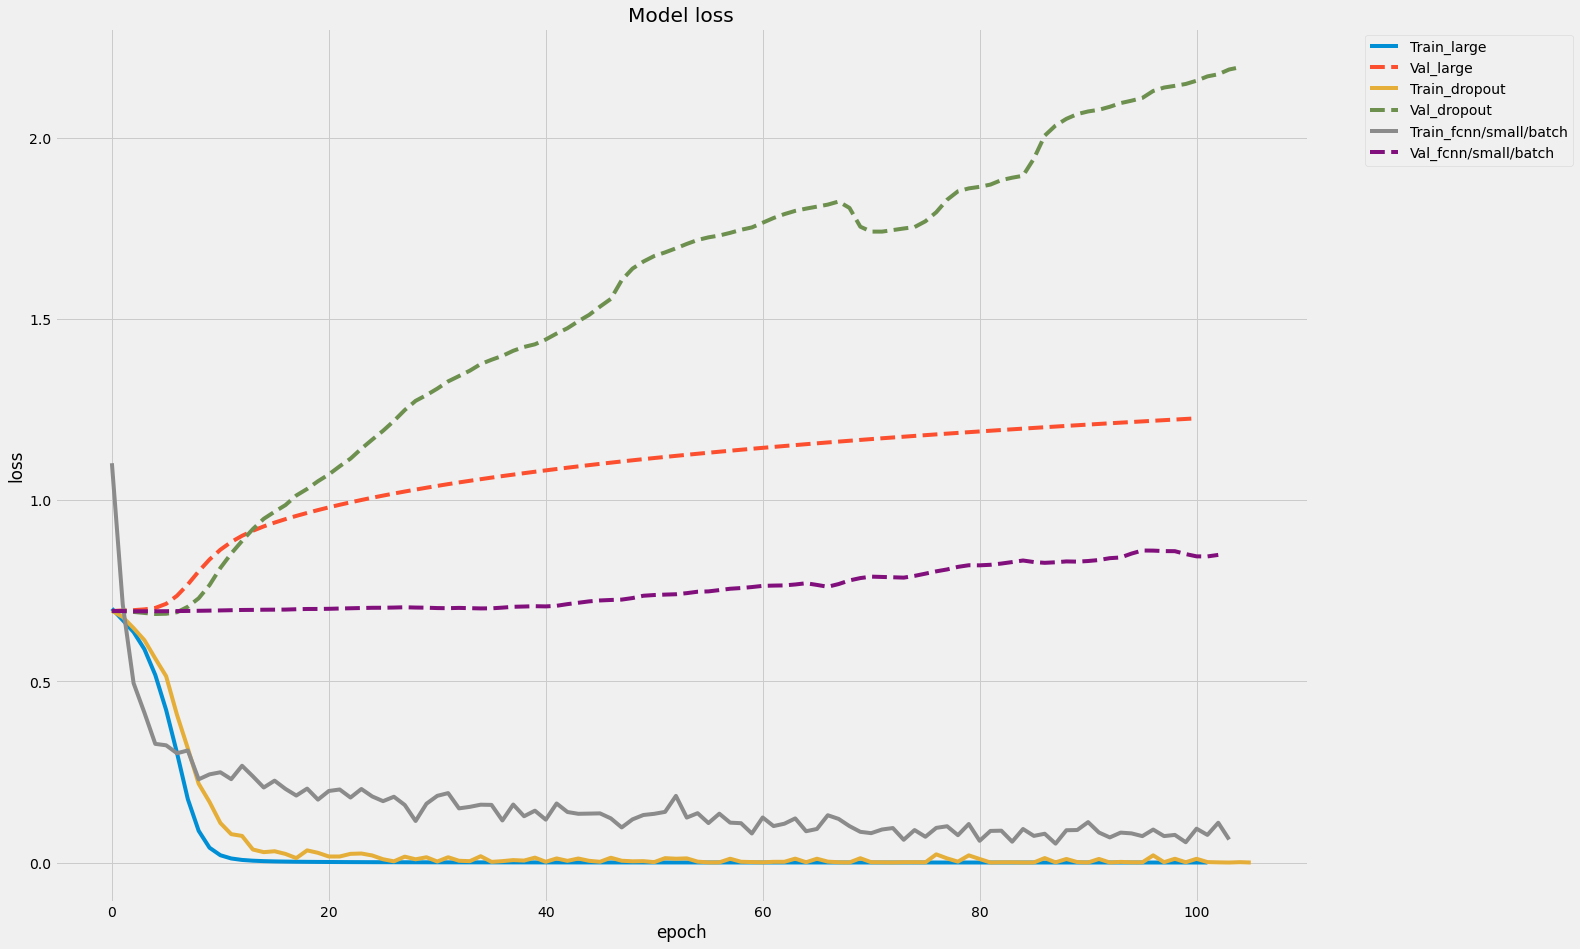

In [42]:
plot_report(batch_histories, 'loss')

## LSTM-FCNN

Univariate time series classification model, the Long Short Term Memory Fully Convolutional Network (LSTM-FCN) to capture time related information

In [44]:
X = features
X.shape

(105, 158, 28)

In [45]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=38)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).take(len(x_train)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).take(len(x_test)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
steps_per_epoch = round(len(train_dataset)/mini_batch_size)

In [46]:
lstm_histories = {}
#lstm_histories['large'] = size_histories['fcnn/large']
#lstm_histories['dropout'] = size_histories['fcnn/tiny/dropout']

In [47]:
lstm_units=128
lstm_tiny_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2),
                         input_shape=[X.shape[1],X.shape[2],]
                        ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
#     tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/tiny'] = compile_and_fit(lstm_tiny_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                                        lr=1e-4,
#                                                                        multiplier=10),
                                               name="lstm/tiny")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(lstm_histories['lstm/tiny'].history["accuracy"]))
print('test acc:', max(lstm_histories['lstm/tiny'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               80384     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 81,937
Trainable params: 81,681
Non-trainable params: 256
_________________________________________________________________
Epoch 1/1000
9/9 [==============================] - 2s 41ms/step - loss: 0.7582 - accuracy: 0.4286 - val_loss: 0.692

Epoch 52/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0288 - accuracy: 1.0000 - val_loss: 1.3694 - val_accuracy: 0.5143
Epoch 53/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0265 - accuracy: 1.0000 - val_loss: 1.4851 - val_accuracy: 0.5143
Epoch 54/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0291 - accuracy: 0.9857 - val_loss: 1.6442 - val_accuracy: 0.5429
Epoch 55/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0322 - accuracy: 1.0000 - val_loss: 1.4389 - val_accuracy: 0.5143
Epoch 56/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0273 - accuracy: 1.0000 - val_loss: 1.5623 - val_accuracy: 0.5143
Epoch 57/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0255 - accuracy: 1.0000 - val_loss: 2.0732 - val_accuracy: 0.5429
Epoch 58/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0245 - accuracy: 1.0000 - val_loss: 1.5939 - val_accuracy: 0.5143
Epoch 59/1000

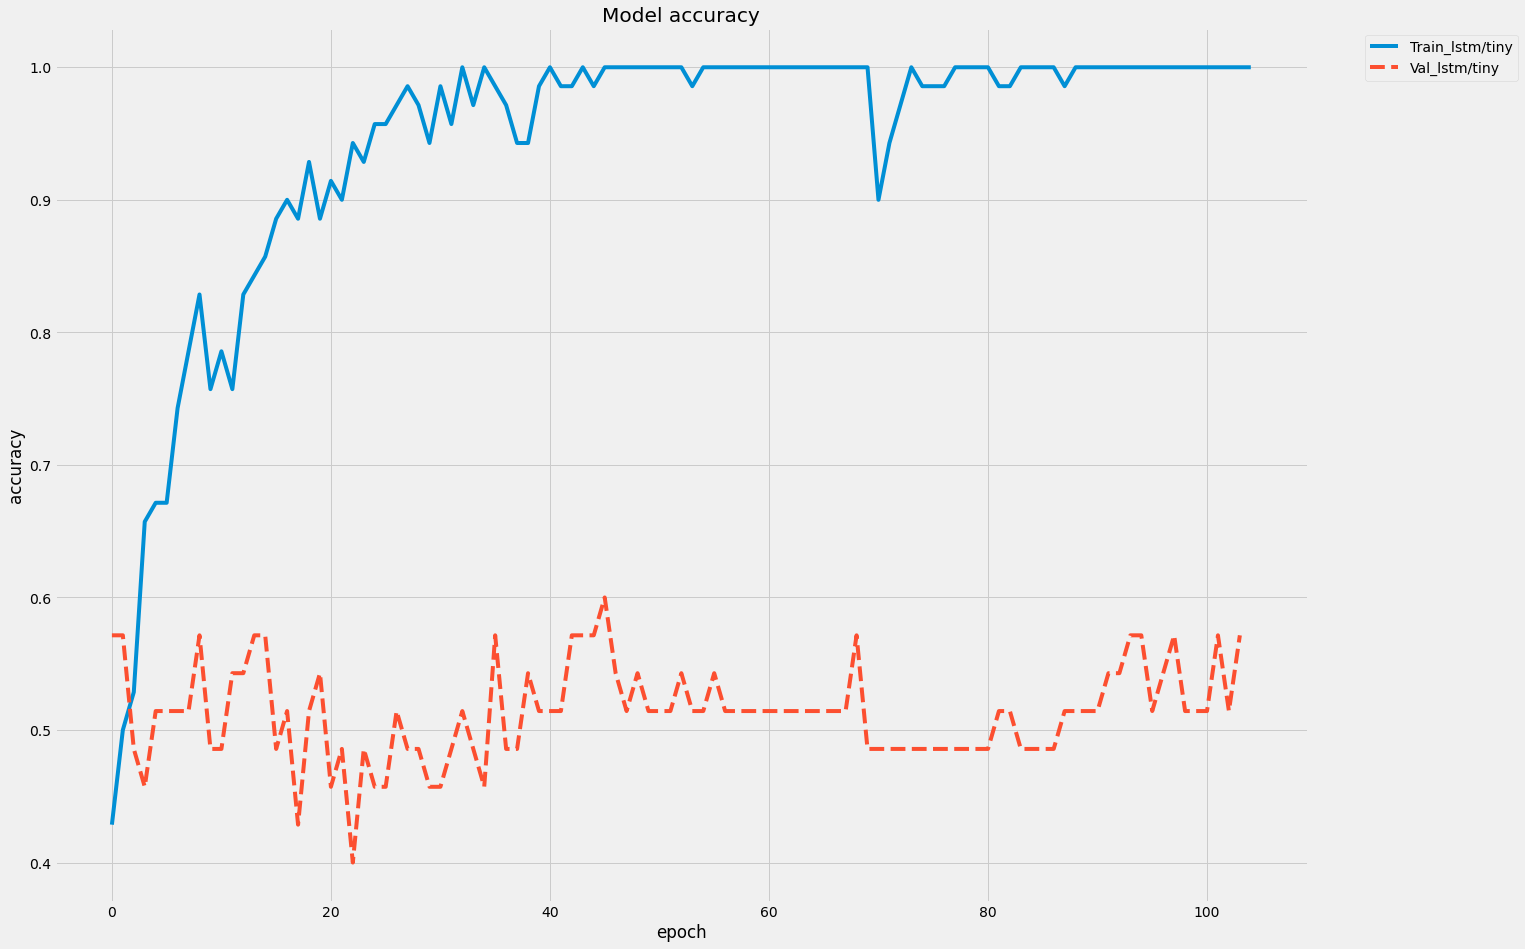

In [48]:
plot_report(lstm_histories, 'accuracy')

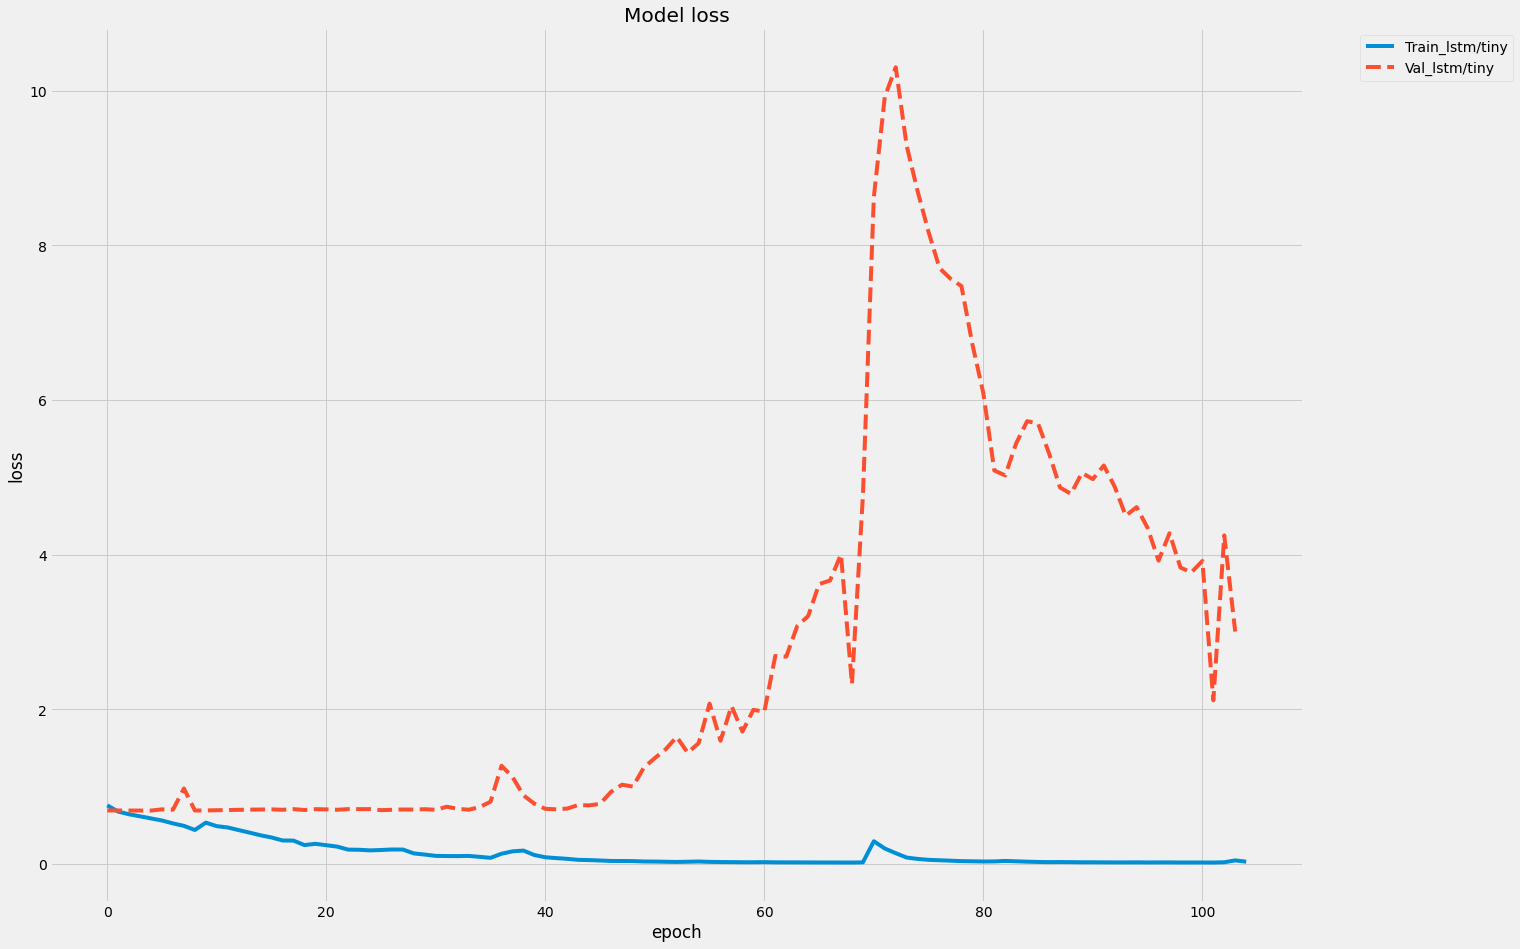

In [49]:
plot_report(lstm_histories, 'loss')

In [52]:
lstm_small_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True,
                        kernel_regularizer=regularizers.l2(lr2),
                         input_shape=[X.shape[1],X.shape[2],]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/small'] = compile_and_fit(lstm_small_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                                        lr=1e-4,
#                                                                        multiplier=10),
                                               name="lstm/small")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(lstm_histories['lstm/small'].history["accuracy"]))
print('test acc:', max(lstm_histories['lstm/small'].history["val_accuracy"]))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 158, 128)          80384     
                                                                 
 batch_normalization_2 (Batc  (None, 158, 128)         512       
 hNormalization)                                                 
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 8)                 1032      
                                                                 
 dropout_1 (Dropout)         (None, 8)                

9/9 [==============================] - 0s 13ms/step - loss: 0.0636 - accuracy: 0.9857 - val_loss: 3.0097 - val_accuracy: 0.5143
Epoch 49/1000
9/9 [==============================] - 0s 13ms/step - loss: 0.0716 - accuracy: 0.9571 - val_loss: 2.8068 - val_accuracy: 0.5143
Epoch 50/1000
9/9 [==============================] - 0s 13ms/step - loss: 0.0433 - accuracy: 0.9857 - val_loss: 1.8610 - val_accuracy: 0.4857
Epoch 51/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.0656 - accuracy: 1.0000 - val_loss: 2.2381 - val_accuracy: 0.5143
Epoch 52/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.0473 - accuracy: 1.0000 - val_loss: 2.0045 - val_accuracy: 0.5143
Epoch 53/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.0538 - accuracy: 0.9714 - val_loss: 1.9873 - val_accuracy: 0.5143
Epoch 54/1000
9/9 [==============================] - 0s 13ms/step - loss: 0.0243 - accuracy: 1.0000 - val_loss: 2.0838 - val_accuracy: 0.5143
Epoch 55/1000
9/9 [=

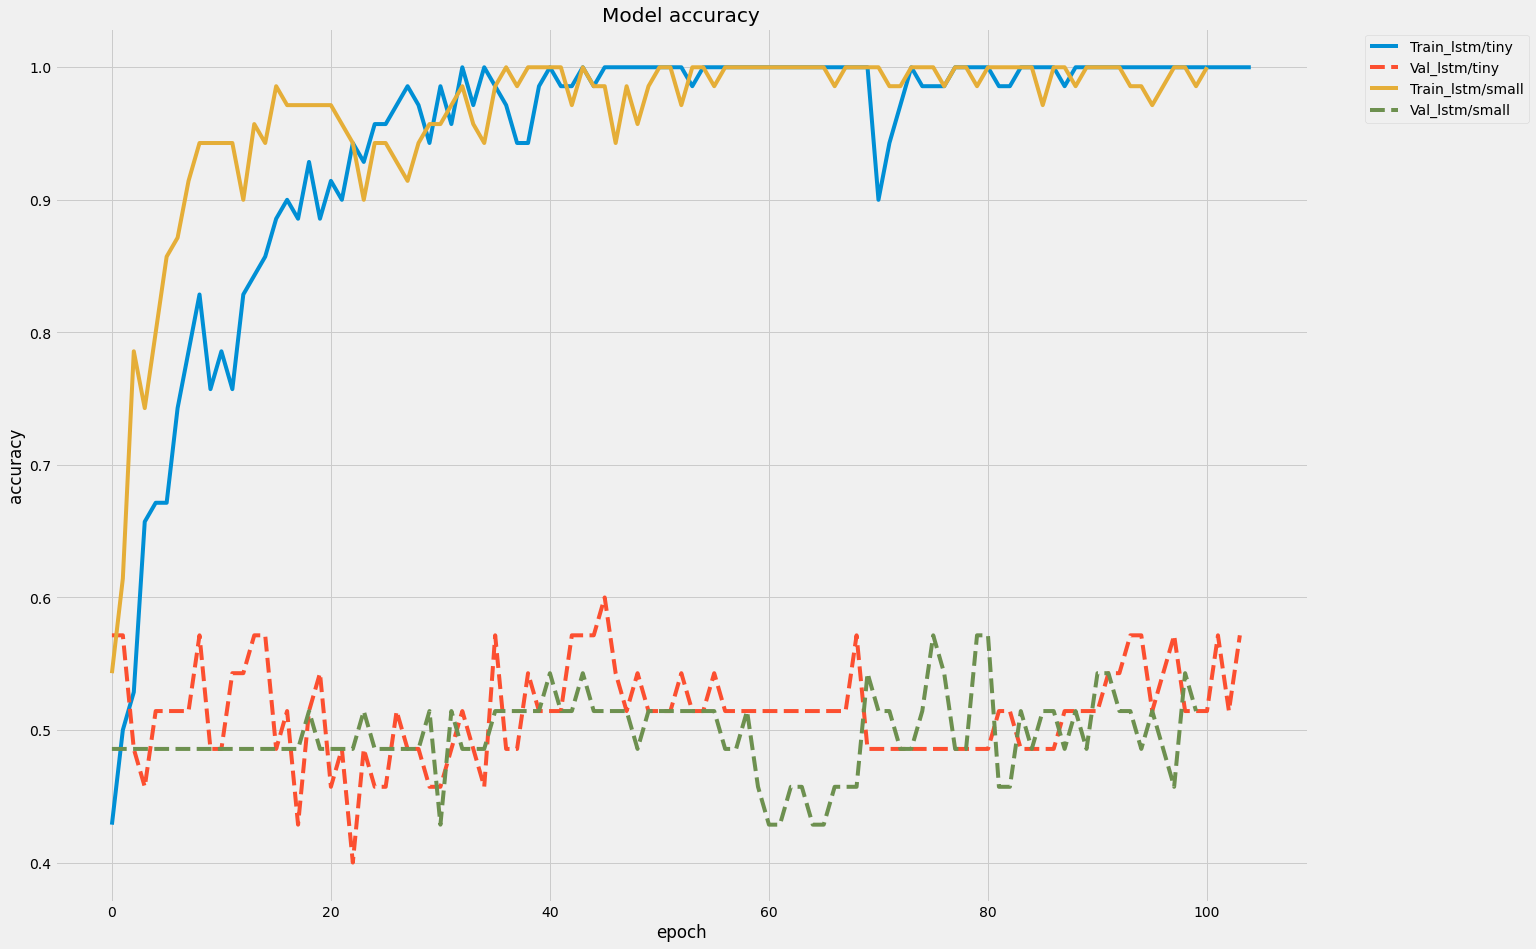

In [53]:
plot_report(lstm_histories, 'accuracy')

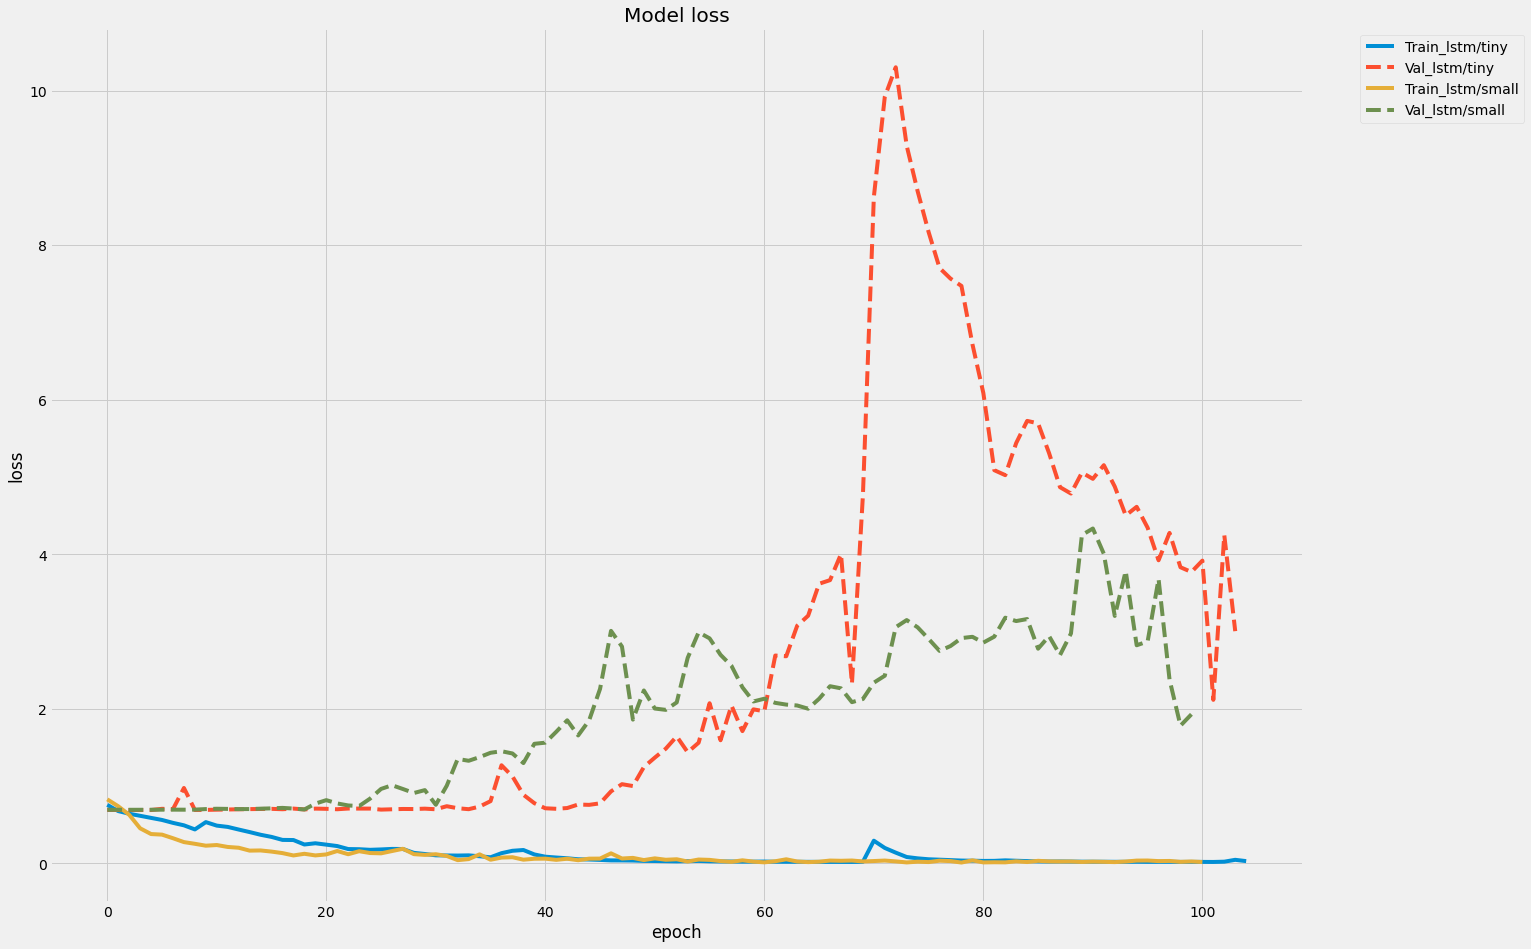

In [54]:
plot_report(lstm_histories, 'loss')

In [55]:
lstm_units=256
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_large_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True,
                        kernel_regularizer=regularizers.l2(lr2),
                         input_shape=[X.shape[1],X.shape[2],]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/large'] = compile_and_fit(lstm_large_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                lr=1e-4,
#                                                multiplier=10), 
                                                name="lstm/large")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(lstm_histories['lstm/large'].history["accuracy"]))
print('test acc:', max(lstm_histories['lstm/large'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 158, 256)          291840    
                                                                 
 batch_normalization (BatchN  (None, 158, 256)         1024      
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 batch_normalization_2 (Batc  (None, 64)               2

Epoch 40/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.1323 - accuracy: 0.9857 - val_loss: 0.9514 - val_accuracy: 0.5143
Epoch 41/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.1394 - accuracy: 0.9857 - val_loss: 0.9593 - val_accuracy: 0.4857
Epoch 42/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.1502 - accuracy: 0.9571 - val_loss: 0.9402 - val_accuracy: 0.4857
Epoch 43/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.1168 - accuracy: 1.0000 - val_loss: 0.9536 - val_accuracy: 0.4857
Epoch 44/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.1347 - accuracy: 0.9857 - val_loss: 0.9924 - val_accuracy: 0.4571
Epoch 45/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.1013 - accuracy: 1.0000 - val_loss: 1.0391 - val_accuracy: 0.5429
Epoch 46/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.1321 - accuracy: 0.9714 - val_loss: 1.0882 - val_accuracy: 0.5714
Epoch 

Epoch 98/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0438 - accuracy: 1.0000 - val_loss: 2.2186 - val_accuracy: 0.4286
Epoch 99/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0421 - accuracy: 1.0000 - val_loss: 2.3180 - val_accuracy: 0.3429
Epoch 100/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0459 - accuracy: 0.9857 - val_loss: 2.2281 - val_accuracy: 0.3429
Epoch 101/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0532 - accuracy: 0.9857 - val_loss: 2.1137 - val_accuracy: 0.3429

#######################EVALUATION######################
train acc: 1.0
test acc: 0.6285714507102966


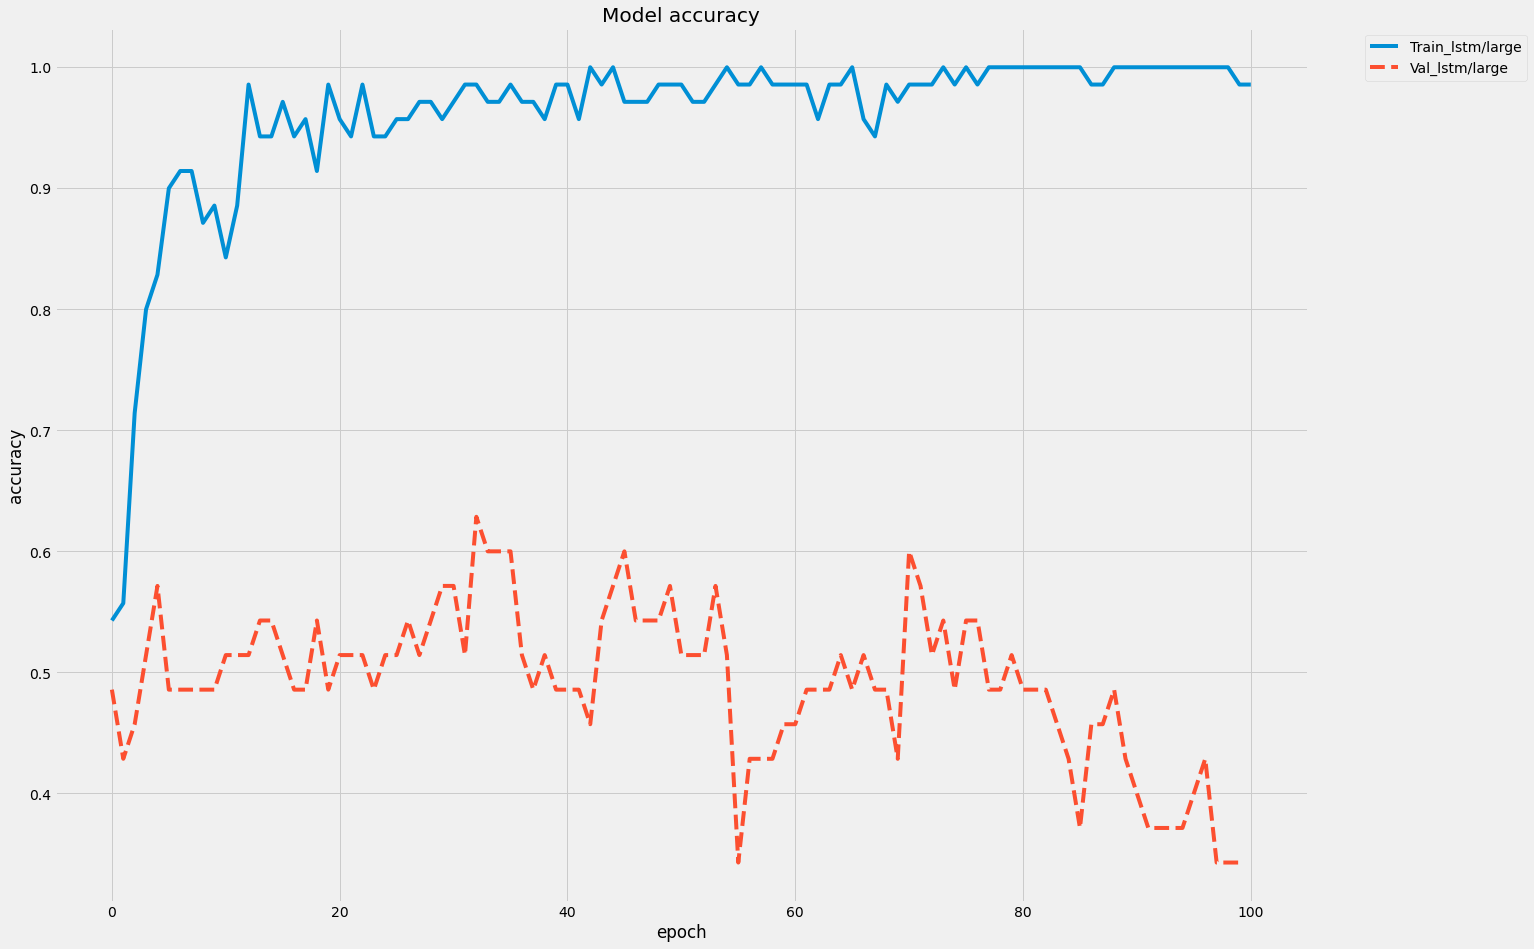

In [56]:
plot_report({'lstm/large':lstm_histories['lstm/large']}, 'accuracy')

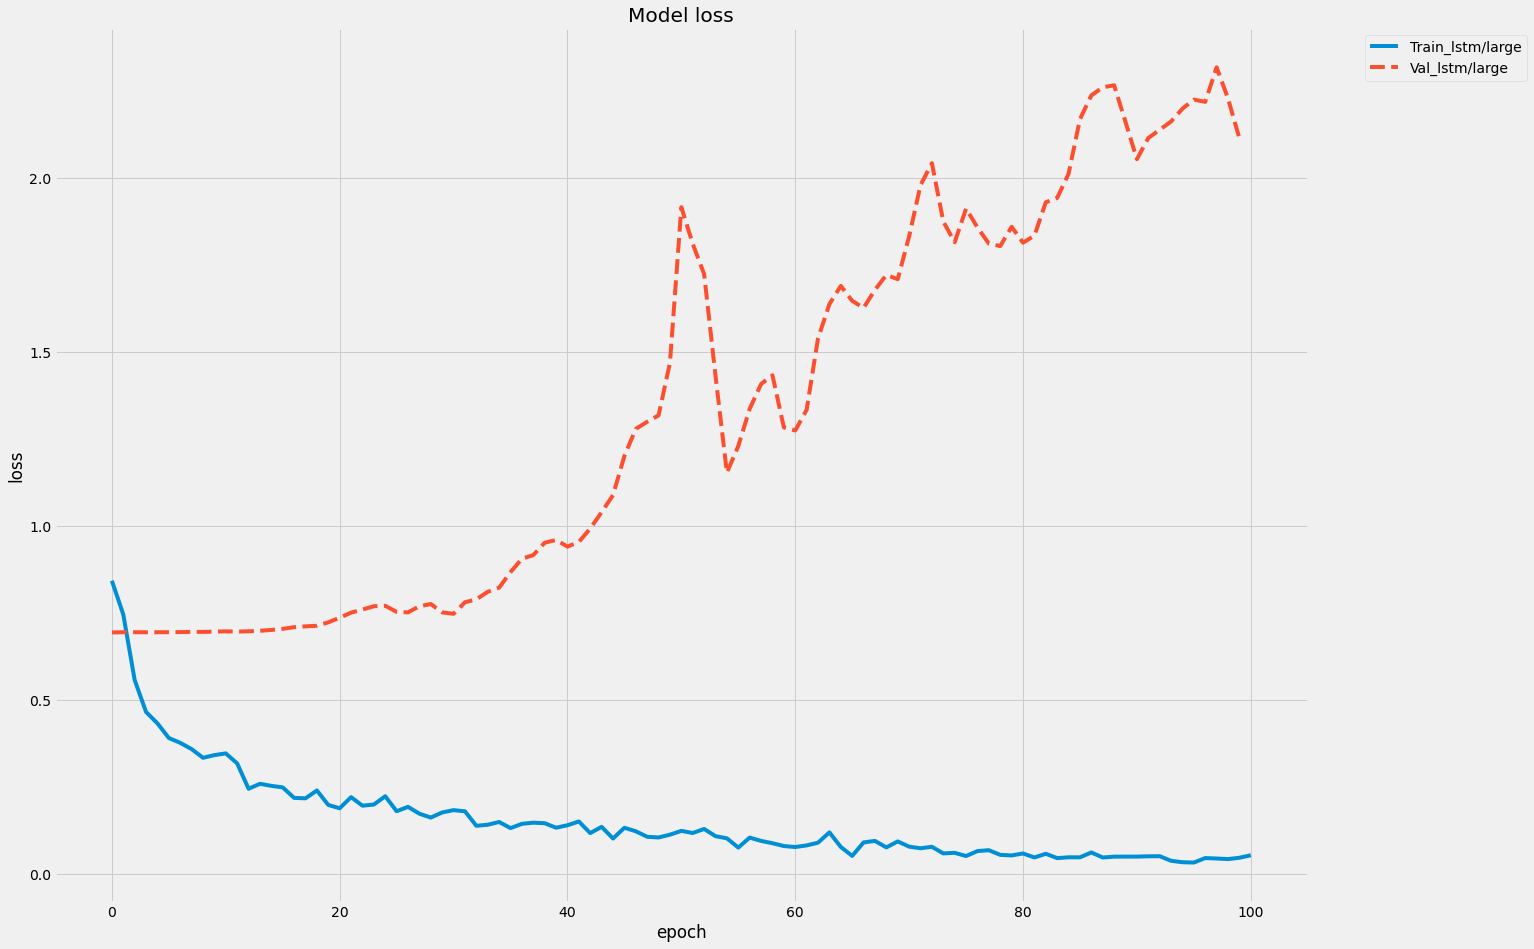

In [57]:
plot_report({'lstm/large':lstm_histories['lstm/large']}, 'loss')